### Imported Libraries and Constants:

In [6]:
import cv2
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from scikeras.wrappers import KerasClassifier

import random

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, roc_curve, auc

import types
import pickle

##### constants:

In [7]:
img_height = 100
img_width = 100
num_classes = 102

### Load Data

In [8]:
def resize_without_squeezing(image, target_size):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    # Calculate new size while preserving aspect ratio
    if aspect_ratio > 1:
        new_w = target_size
        new_h = int(target_size / aspect_ratio)
    else:
        new_h = target_size
        new_w = int(target_size * aspect_ratio)

    # Resize the image
    resized_img = cv2.resize(image, (new_w, new_h))

    # Create a canvas with the target size and fill with padding color
    canvas = np.full((target_size, target_size, 3), (255,255,255), dtype=np.uint8)

    # Calculate the position to paste the resized image in the center
    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_img

    return canvas

In [9]:
def get_folders_in_directory(directory_path):
    # Get the list of all files and folders in the specified directory
    items = os.listdir(directory_path)
    # Filter out only the folders from the list
    folders = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]
    return folders
    
def load_images_from_folder(folder):
    # Function to load and preprocess images from a folder
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = resize_without_squeezing(img,img_height)
            #img = cv2.resize(img, (img_height, img_width))
            images.append(img)
    return images



base_dir = '../data/dataset'
labels_name = get_folders_in_directory(base_dir) # get the list of folder names
labels_dict = {label:i for i,label in enumerate(labels_name)} # assign an int for each folder name = asana

In [10]:
# Get all images and corresp labels
all_images=[]
all_labels=[]
d={}
for label in labels_name:
    new_images = load_images_from_folder(base_dir+'/'+label)
    d[label]=len(new_images)
    all_images = all_images + new_images
    for i in range(len(new_images)):
        all_labels.append(labels_dict[label])

# Ensure that all_image_paths and all_labels are numpy arrays for easier manipulation
images = np.array(all_images)/255 # normalize images to the range [0-1]
labels = np.array(all_labels)

# Shuffle indices
indices = np.arange(len(images))
np.random.shuffle(indices)

# Use the shuffled indices to reorder X and y
images_shuffled = images[indices]
labels_shuffled = labels[indices]

images = images_shuffled
labels = labels_shuffled

In [12]:
# number of images for each folder
sorted_d = dict(sorted(d.items(), key=lambda item: item[1]))
sorted_d

{'phalakasana': 26,
 'garbha pindasana': 27,
 'eka pada rajakapotasana ii': 30,
 'ganda bherundasana': 30,
 'marichyasana i': 30,
 'parsvottanasana': 30,
 'hanumanasana': 31,
 'tadasana': 31,
 'utthita ashwa sanchalanasana': 32,
 'ashtanga namaskara': 33,
 'agnistambhasana': 34,
 'eka pada koundinyanasana i': 34,
 'bhekasana': 35,
 'kurmasana': 35,
 'pincha mayurasana': 35,
 'virabhadrasana i': 35,
 'janu sirsasana': 36,
 'krounchasana': 36,
 'parivrtta parsvakonasana': 36,
 'ardha bhekasana': 37,
 'simhasana': 37,
 'anantasana': 39,
 'bhairavasana': 39,
 'durvasasana': 39,
 'parighasana': 39,
 'parivrtta janu sirsasana': 39,
 'pasasana': 41,
 'vajrasana': 41,
 'yoganidrasana': 41,
 'baddha konasana': 43,
 'kapotasana': 43,
 'uttanasana': 43,
 'dwi pada viparita dandasana': 44,
 'malasana': 44,
 'marichyasana iii': 44,
 'marjaryasana': 44,
 'vrischikasana': 44,
 'dhanurasana': 45,
 'salamba bhujangasana': 45,
 'uttana shishosana': 45,
 'ardha pincha mayurasana': 46,
 'mayurasana': 46,


### Model

In [55]:
# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
        rotation_range = 30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip = True
        #preprocessing_function=add_noise
)

In [56]:
def create_DN2():
    # adding BatchNormalization
    ptrain_model = tf.keras.applications.DenseNet121(input_shape=(img_height,img_width,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
    ptrain_model.trainable = False
    
    inputs = ptrain_model.input

    # Trying different configurations, such as [512, 256], [256, 128], etc., could be beneficial.
    drop_layer = tf.keras.layers.Dropout(0.25)(ptrain_model.output)
    x_layer = tf.keras.layers.Dense(512, activation='relu')(drop_layer)
    x_layer = tf.keras.layers.BatchNormalization()(x_layer)
    
    x_layer1 = tf.keras.layers.Dense(256, activation='relu')(x_layer)
    x_layer1 = tf.keras.layers.BatchNormalization()(x_layer1)
    
    drop_layer1 = tf.keras.layers.Dropout(0.20)(x_layer1)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(drop_layer1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
                  
    return model 

In [57]:
def compile_model(model, optimizer, metrics):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
    return model

In [58]:
def save_model(model):
    model_file = '../models/param_iteration_dn.pkl'
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)

### Split data

In [59]:
# Split the dataset into training and temporary sets (combined validation and test)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

# Split the temporary set into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42
)

train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)

### Train Model

In [60]:
def train_model(train_data, val_data, test_data, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot, model_type, optimizer, batch_size, num_epochs, metrics=['accuracy']):

    result_dict = {}
    result_dict["optimizer"] = optimizer
    result_dict["num_epochs"] = num_epochs
    result_dict["batch_size"] = batch_size
   
    if model_type == 'CNN':
        model = create_CNN()
    elif model_type == 'DenseNet':
        model = create_DN2()
    # optimizer
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True)
    if optimizer=='adam':
        opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    elif optimizer=='rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
    elif optimizer=='SGD':
        opt = keras.optimizers.SGD(learning_rate=lr_schedule)

    # compile model
    model = compile_model(model, opt, metrics)

    # train model
    early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, verbose=1, patience = 5, restore_best_weights=True)

    train_datagen = datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size)
    val_datagen = datagen.flow(val_data, val_labels_one_hot, batch_size=batch_size)
    history = model.fit(train_datagen, epochs=num_epochs, callbacks=[early_stopping], validation_data=val_datagen)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_data, test_labels_one_hot)
    print(f'Test accuracy: {test_acc}')

    result_dict["actual_num_epochs"] = len(history.history['loss'])
    result_dict["accuracy"] = test_acc
    return result_dict, model       

### Import model

In [ ]:
model_file = '../models/param_iteration_dn.pkl'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

### 'main'

In [61]:
opt='adam'
b_size= 32
n_ep=30

In [62]:
d, model = train_model(train_data, val_data, test_data, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot, 
                            'DenseNet', opt, b_size, n_ep, metrics=['accuracy'])

Epoch 1/30
109/109 [==============================] - 44s 336ms/step - loss: 4.5731 - accuracy: 0.0586 - val_loss: 3.8931 - val_accuracy: 0.1299
Epoch 2/30
109/109 [==============================] - 32s 289ms/step - loss: 3.4787 - accuracy: 0.1579 - val_loss: 3.1876 - val_accuracy: 0.2209
Epoch 3/30
109/109 [==============================] - 32s 293ms/step - loss: 3.0875 - accuracy: 0.2288 - val_loss: 2.9800 - val_accuracy: 0.2343
Epoch 4/30
109/109 [==============================] - 32s 291ms/step - loss: 2.8632 - accuracy: 0.2718 - val_loss: 2.7041 - val_accuracy: 0.2838
Epoch 5/30
109/109 [==============================] - 30s 274ms/step - loss: 2.6994 - accuracy: 0.3108 - val_loss: 2.6658 - val_accuracy: 0.2825
Epoch 6/30
109/109 [==============================] - 31s 287ms/step - loss: 2.5892 - accuracy: 0.3186 - val_loss: 2.5469 - val_accuracy: 0.3307
Epoch 7/30
109/109 [==============================] - 39s 357ms/step - loss: 2.4864 - accuracy: 0.3522 - val_loss: 2.5696 - val_ac

### AUC-ROC

In [71]:
# labels_dict2 = {i:labels_name[i] for i in range(len(labels_name))}
#labels_df = pd.DataFrame(list(labels_dict2.items()), columns=['Pose ID', 'Pose Name'])
#labels_df.to_csv("../data/labels_legend.csv",index=False)

In [ ]:
legend = pd.read_csv("../data/labels_legend.csv")
legend_dict = legend.set_index("Pose ID")["Pose Name"].to_dict()

###### 1

24/24 [==============================] - 5s 196ms/step


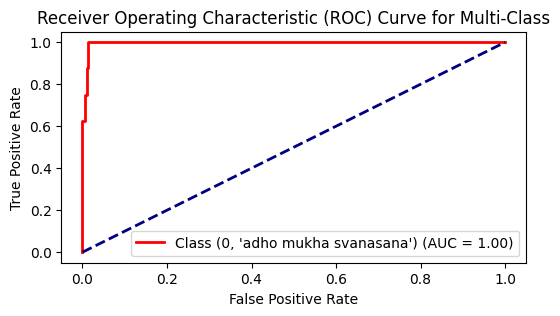

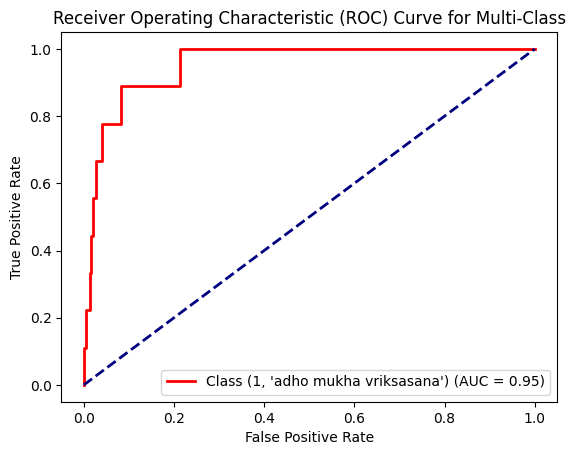

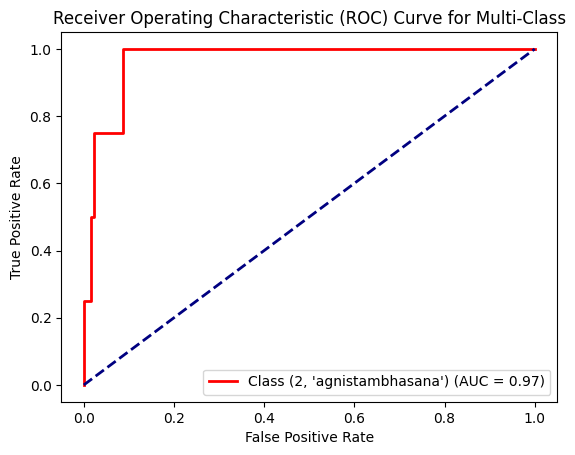

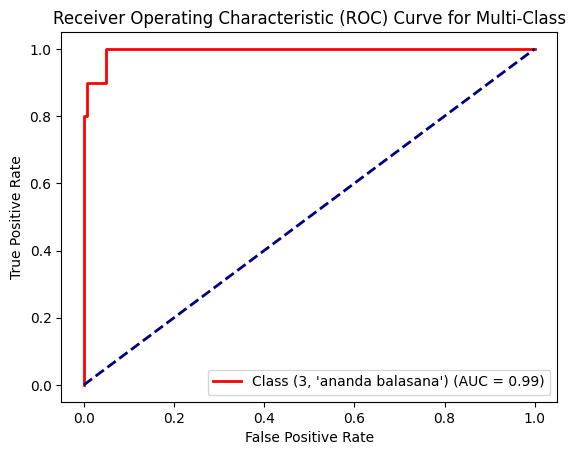

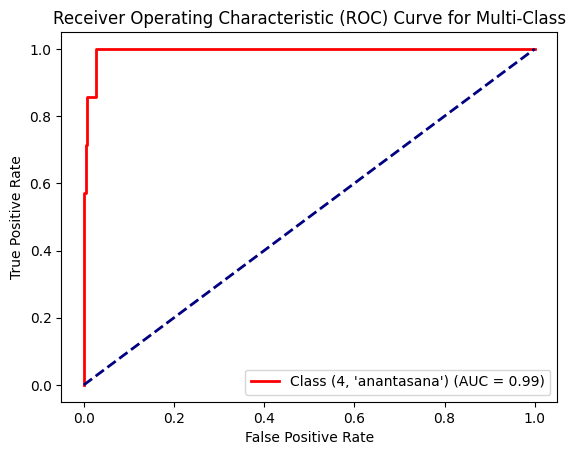

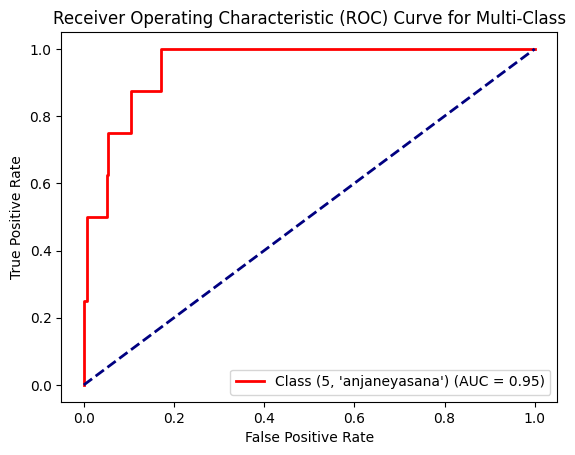

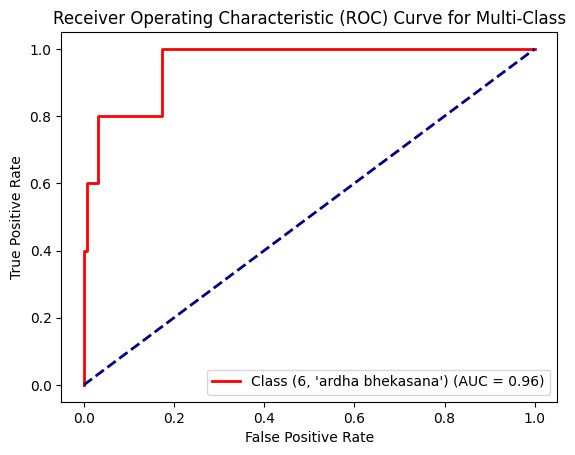

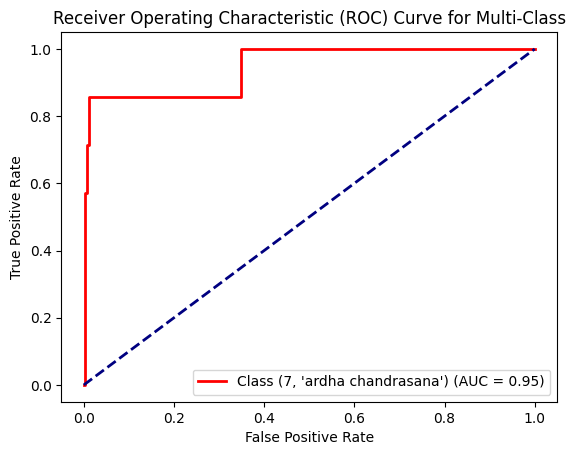

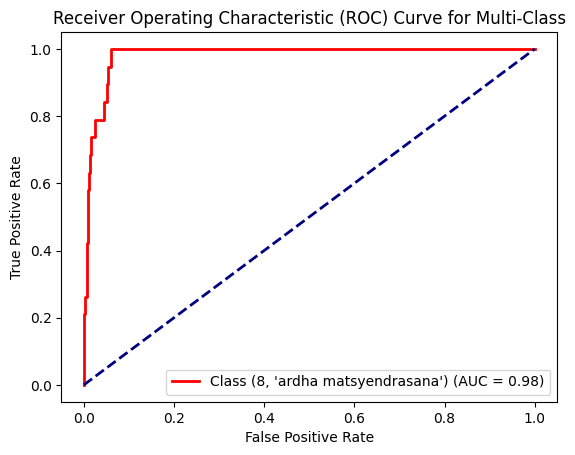

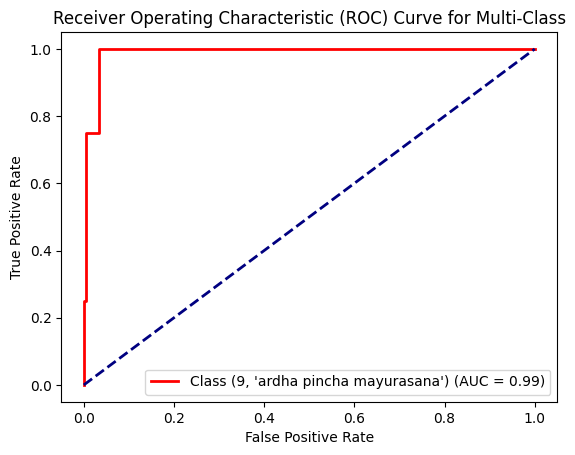

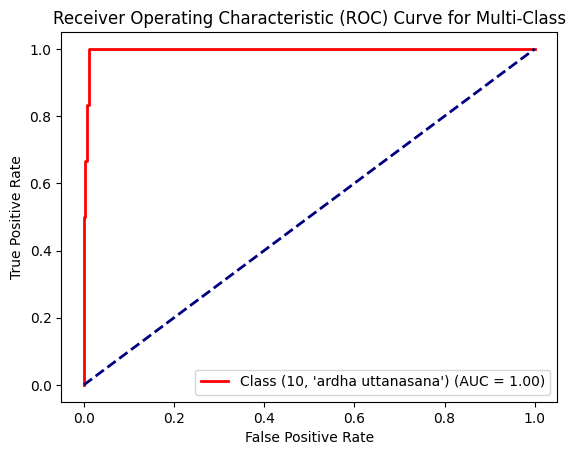

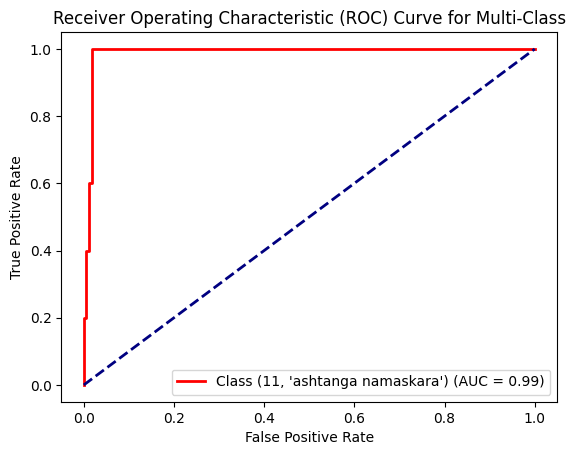

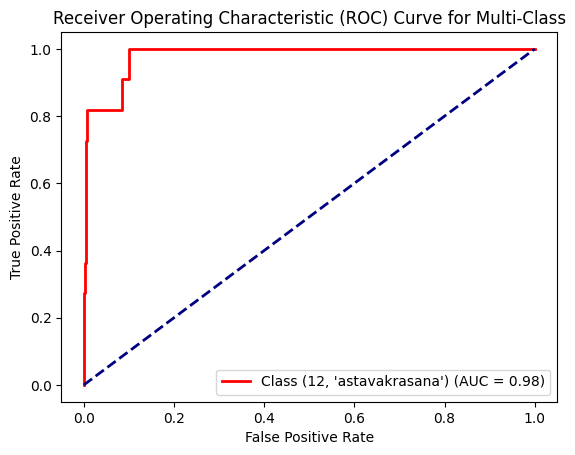

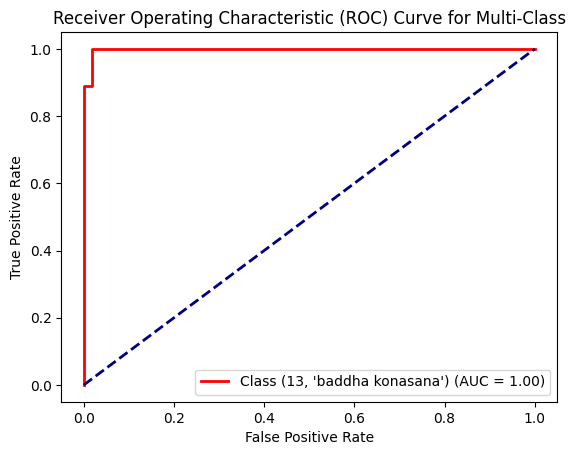

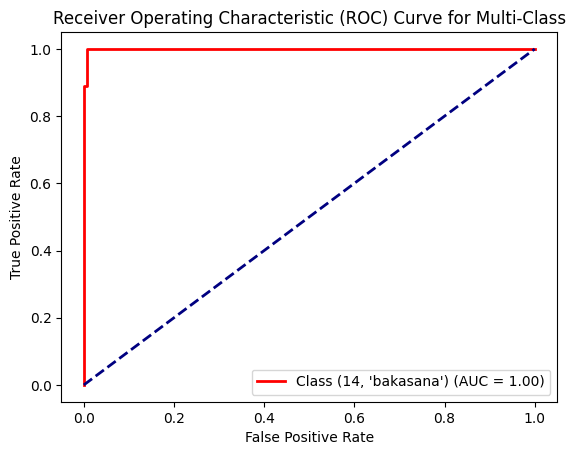

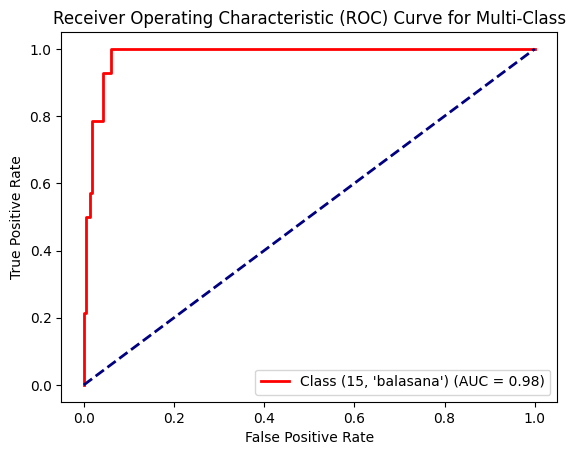

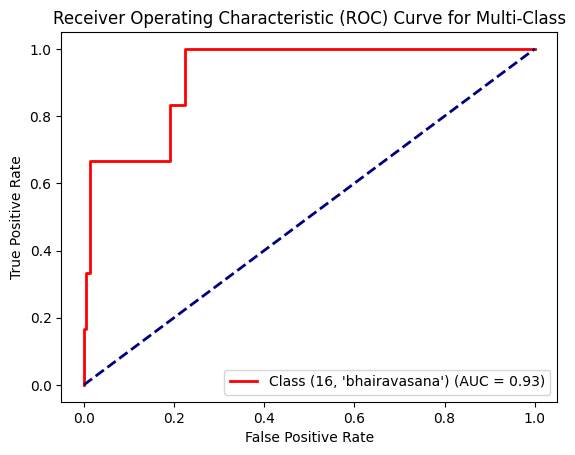

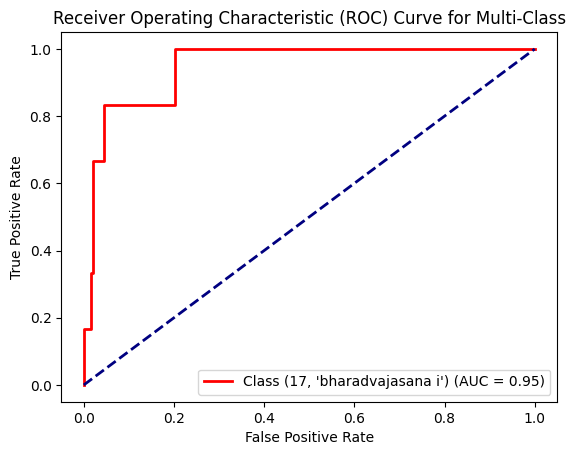

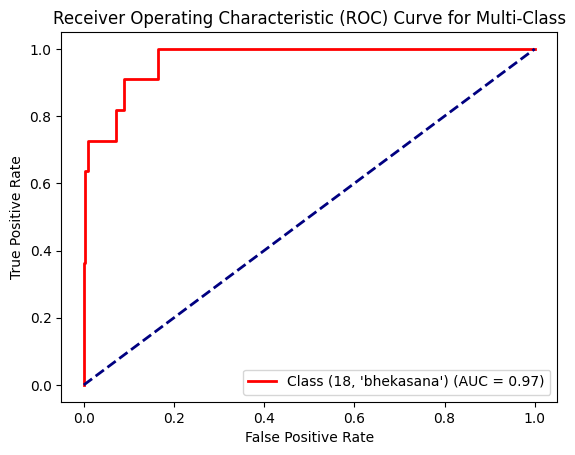

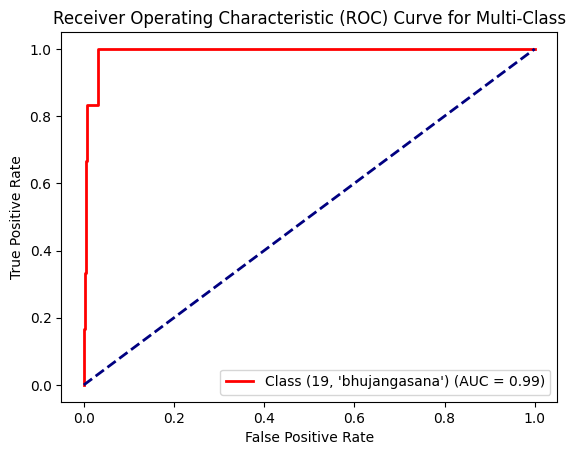

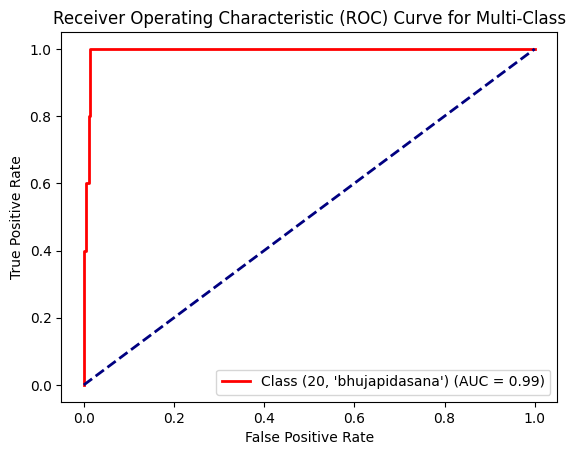

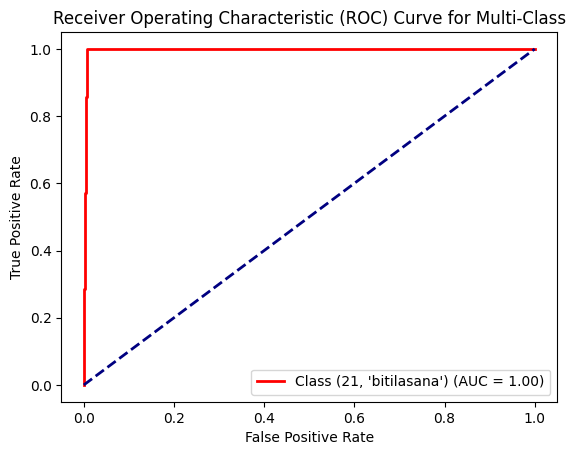

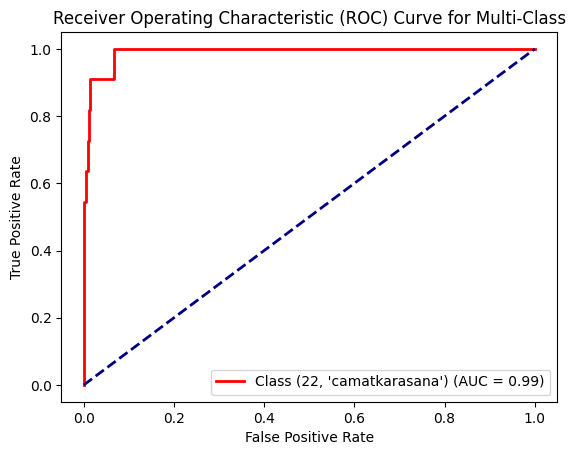

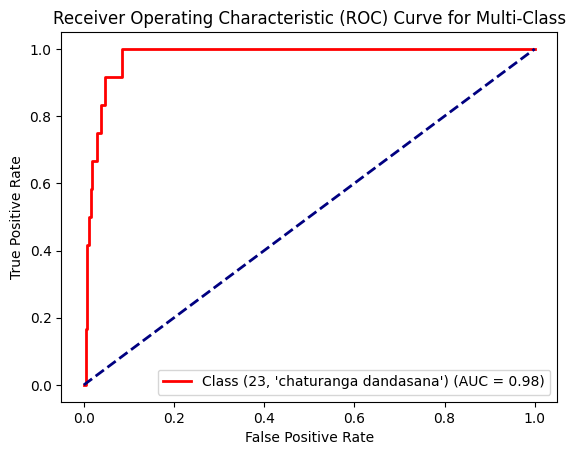

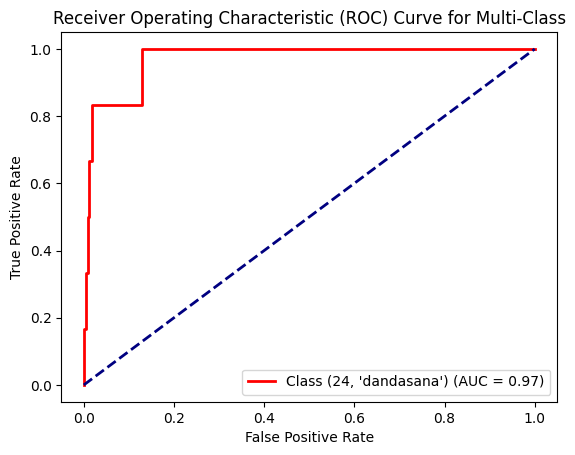

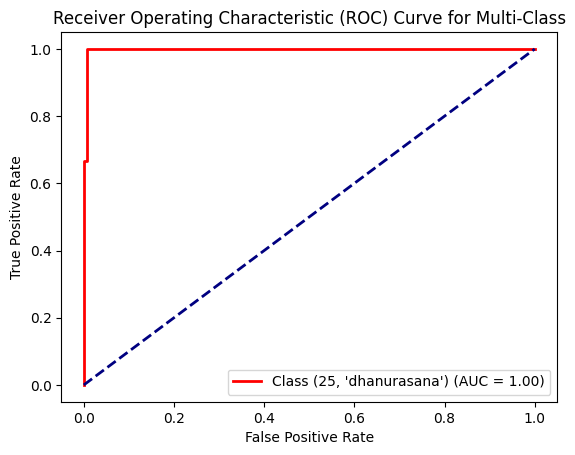

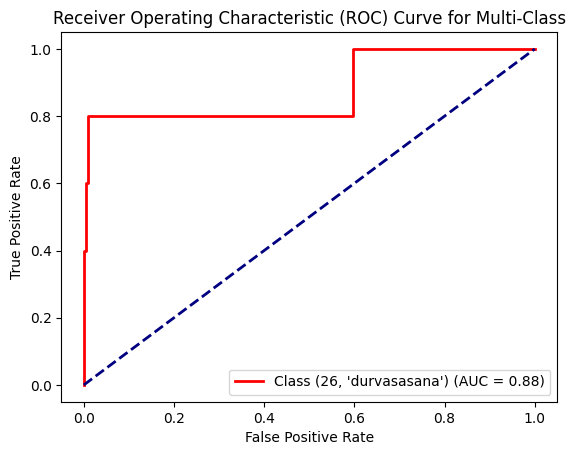

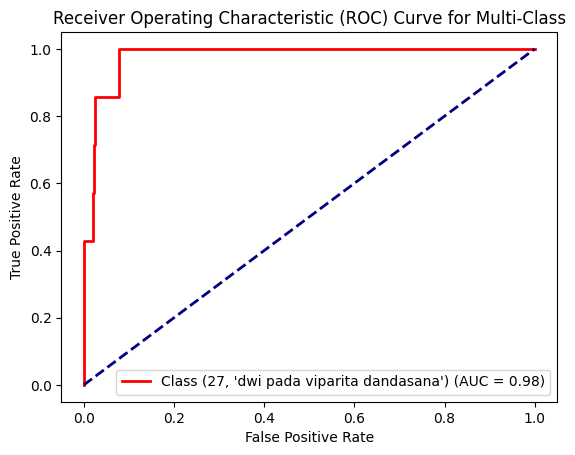

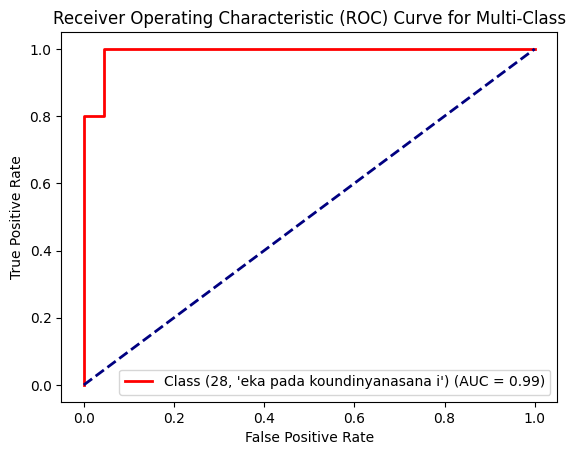

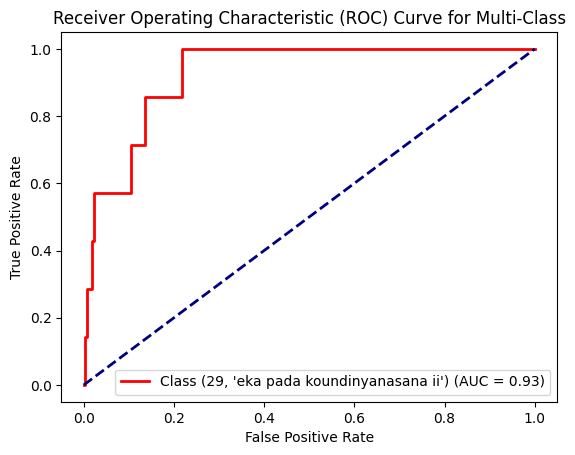

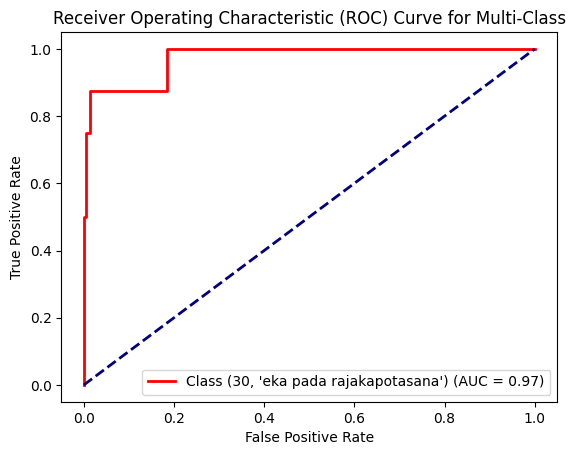

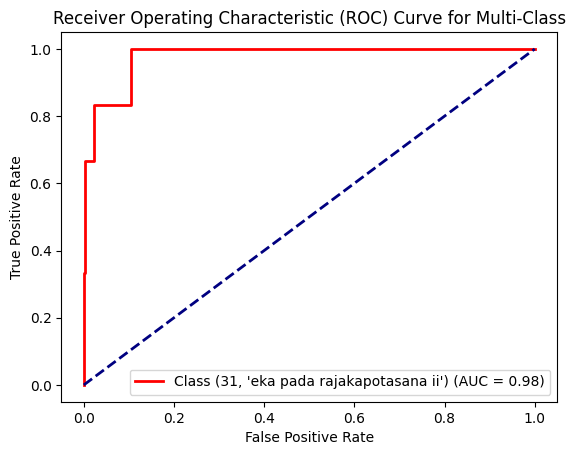

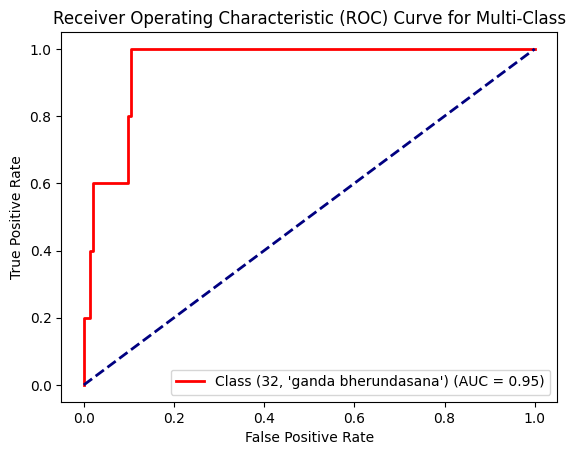

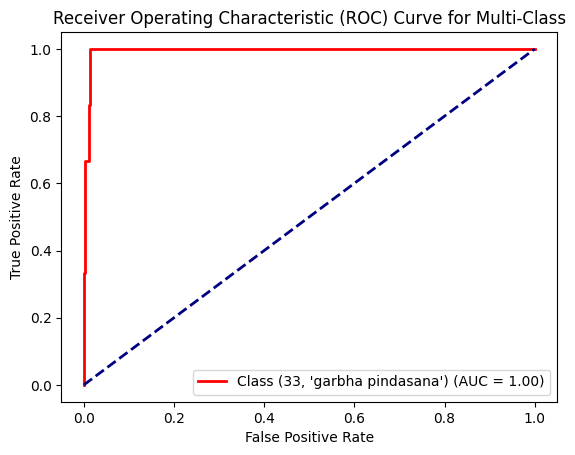

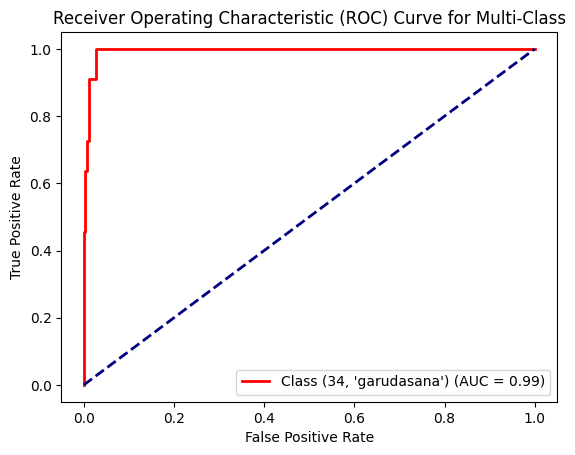

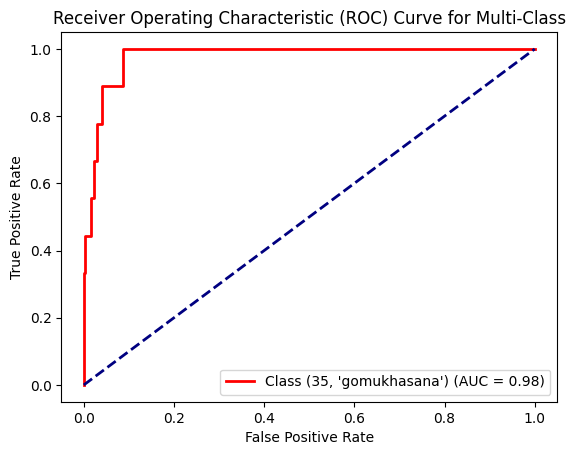

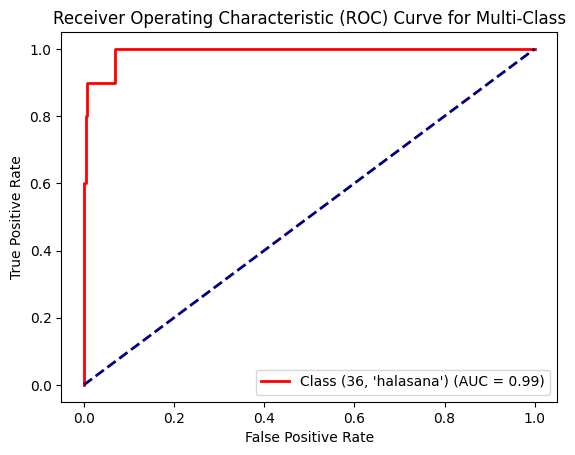

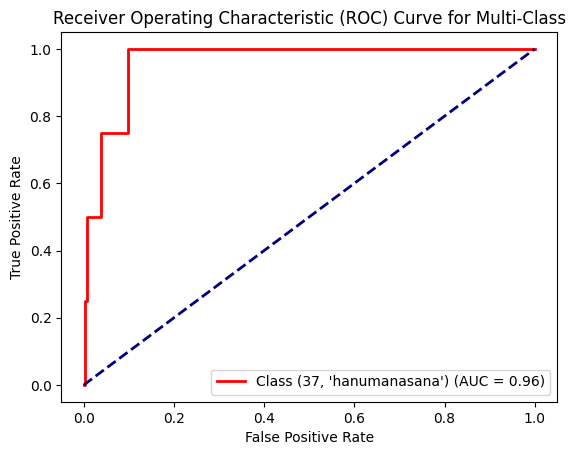

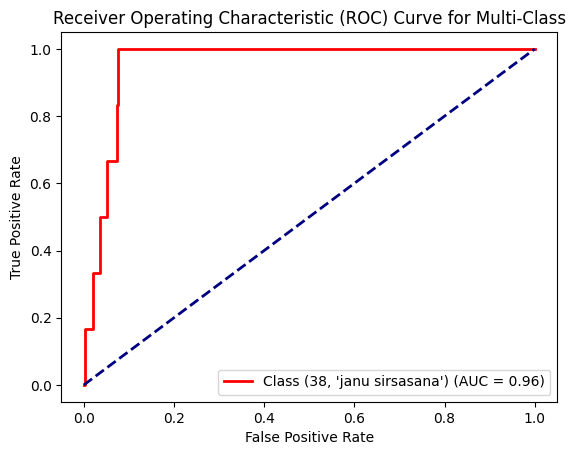

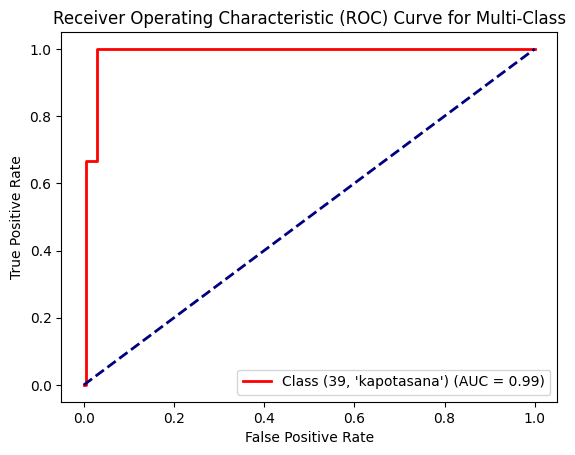

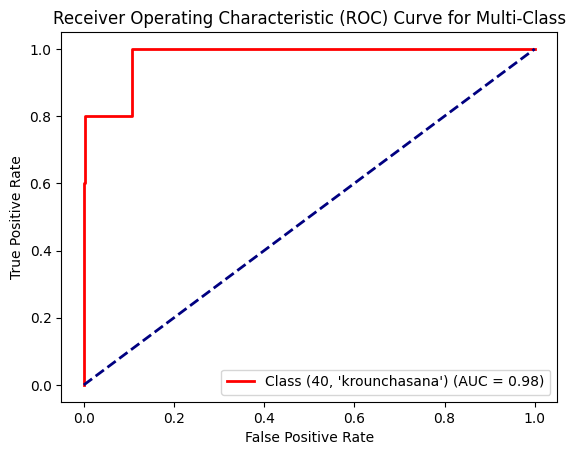

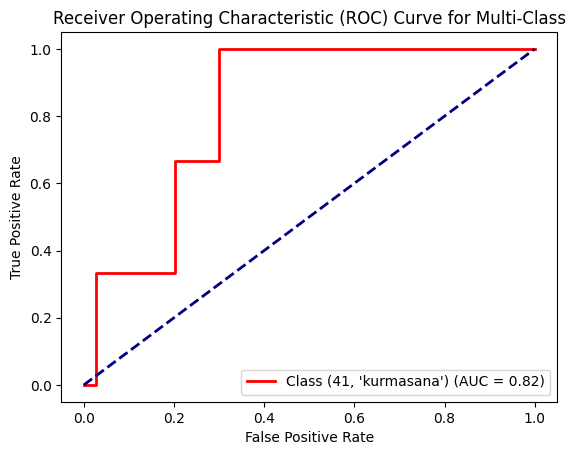

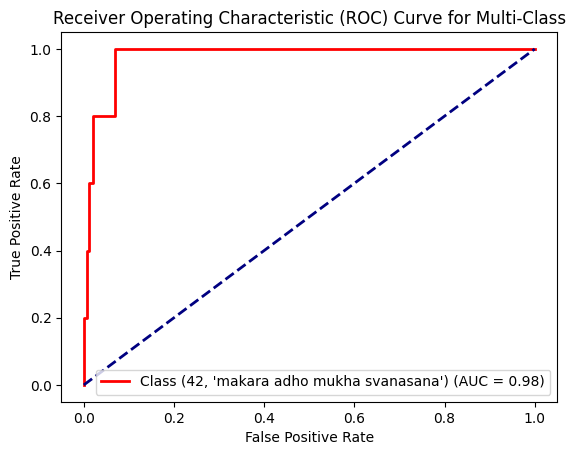

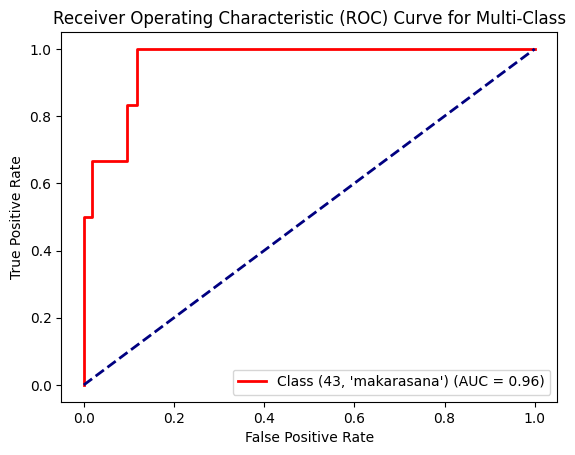

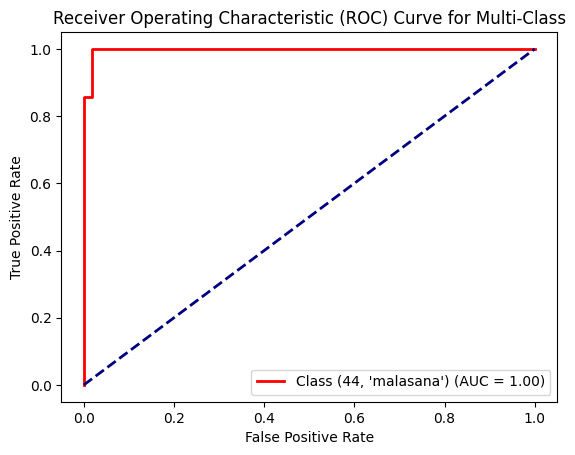

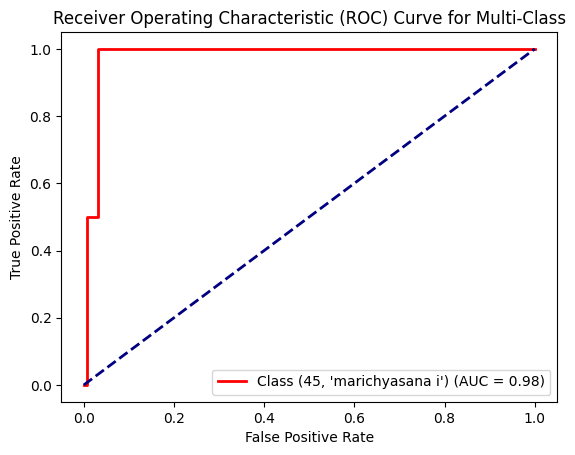

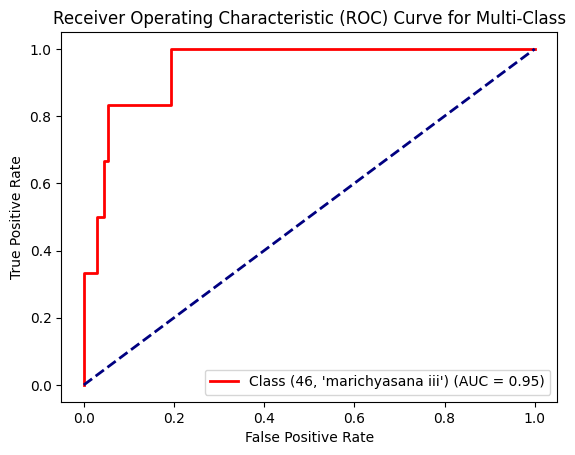

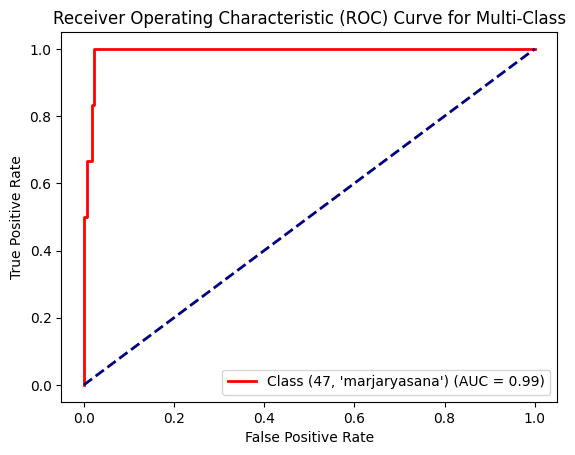

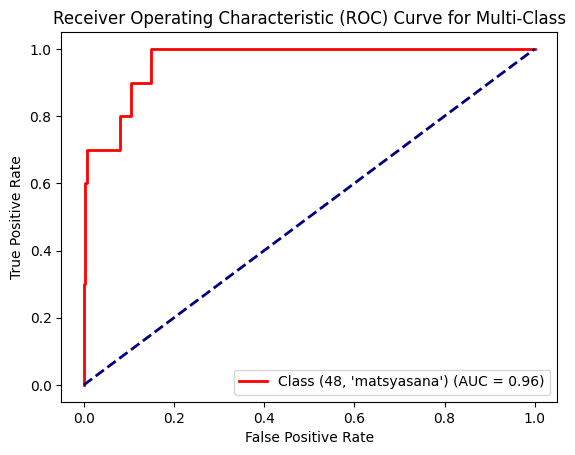

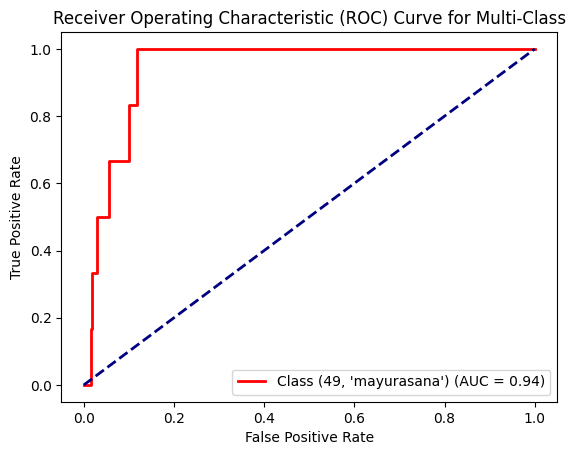

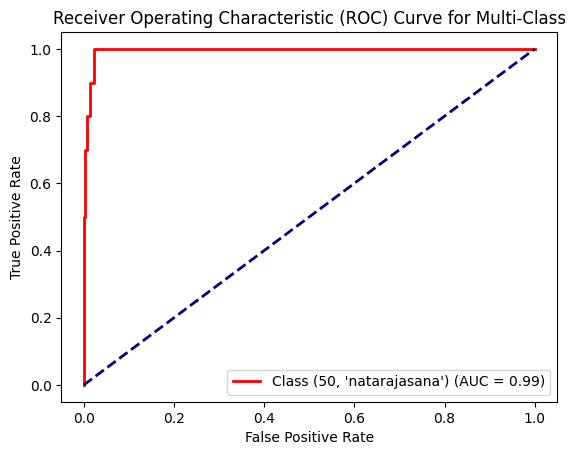

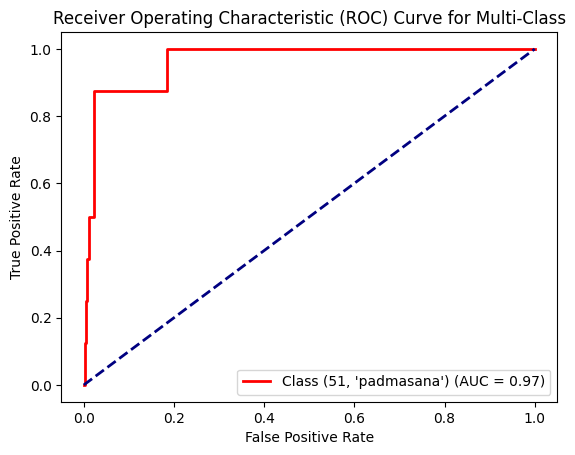

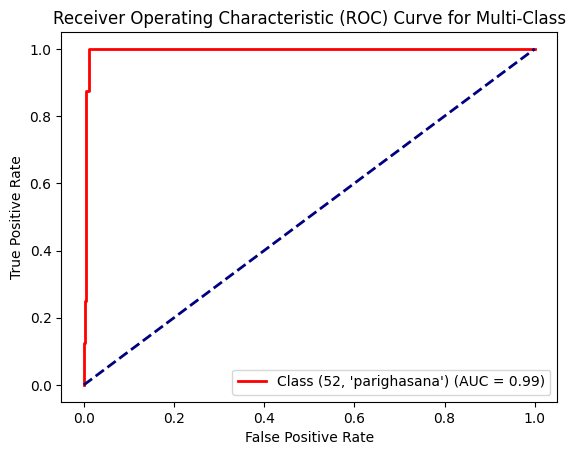

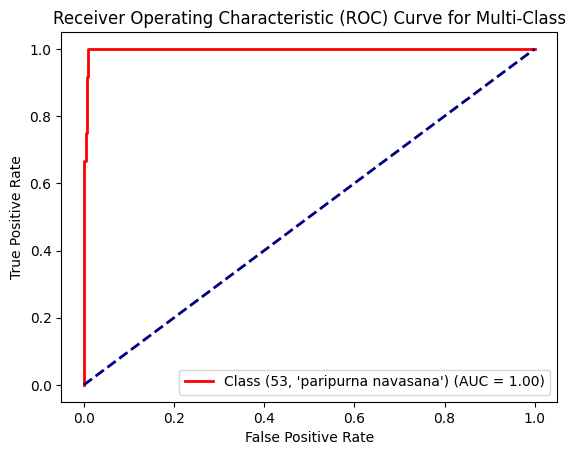

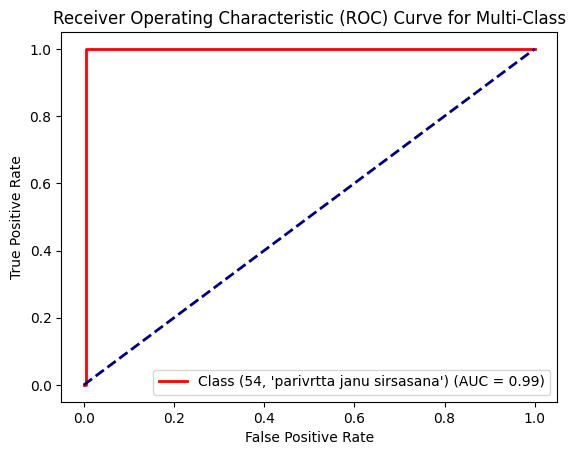

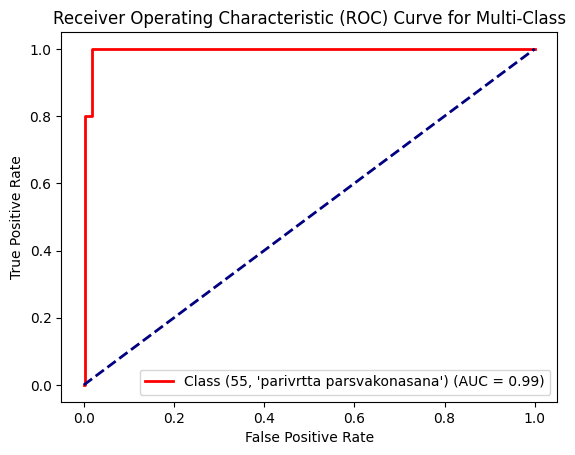

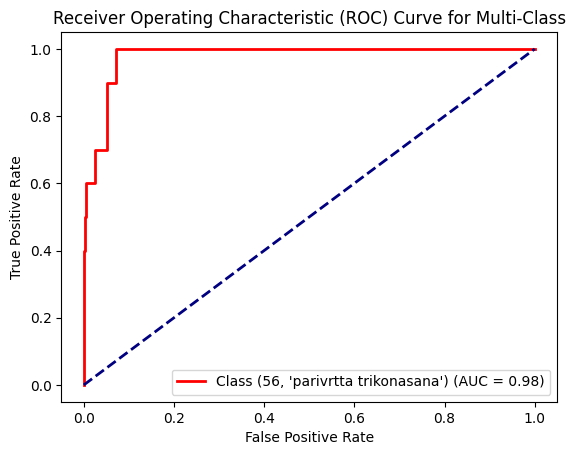

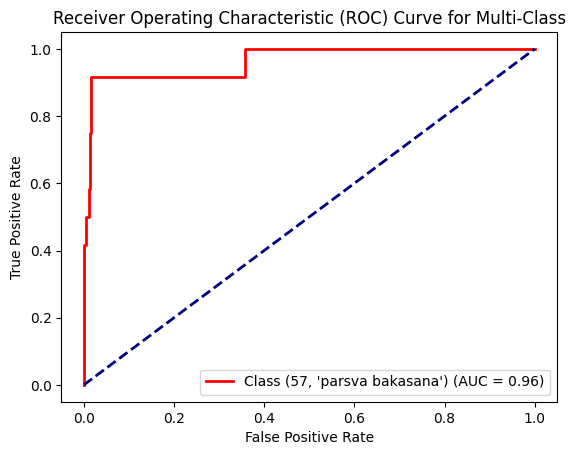

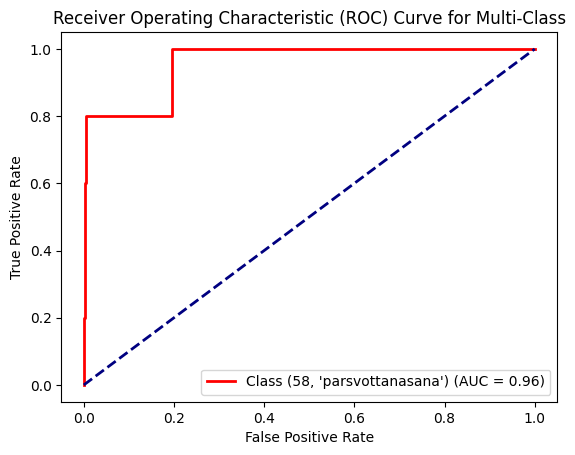

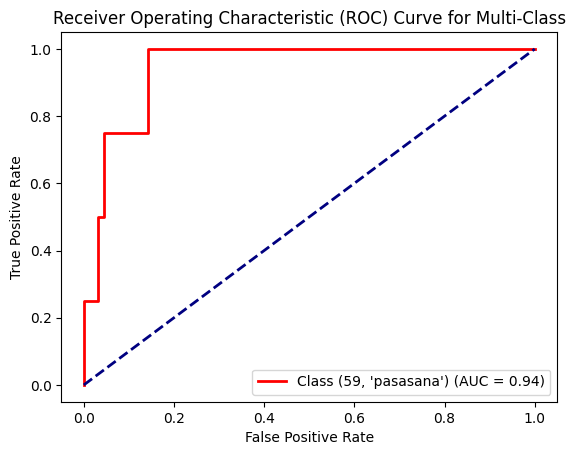

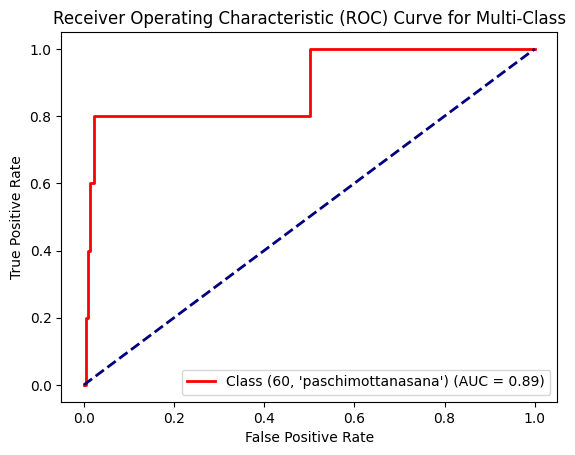

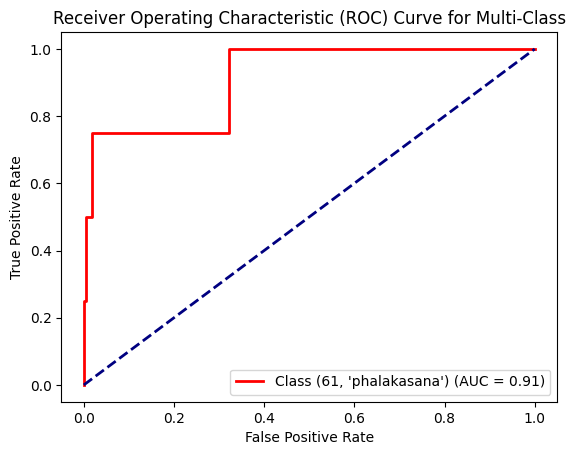

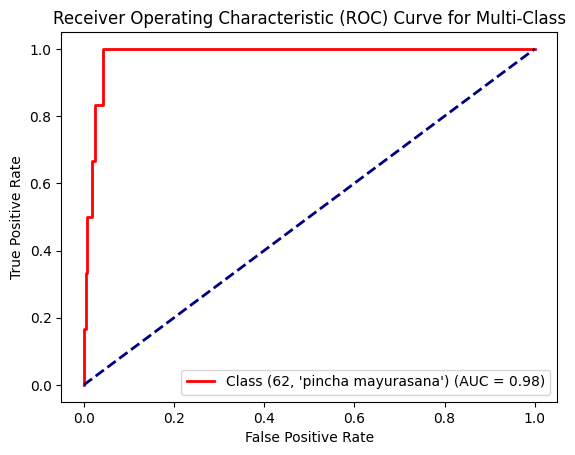

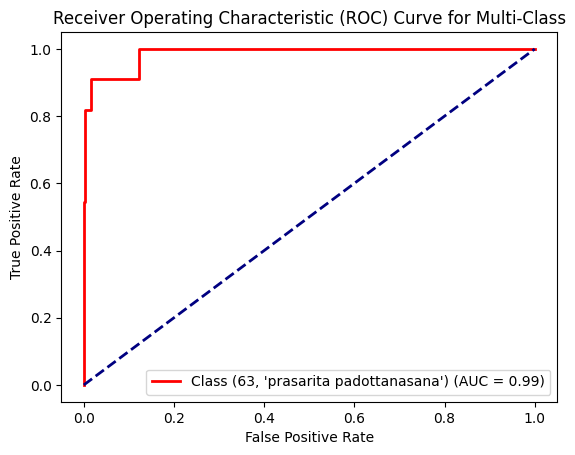

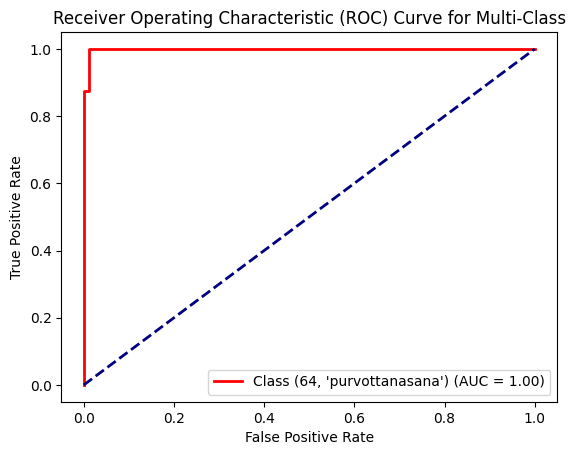

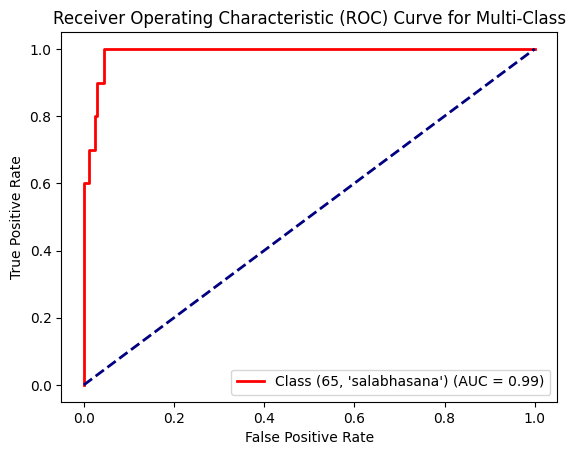

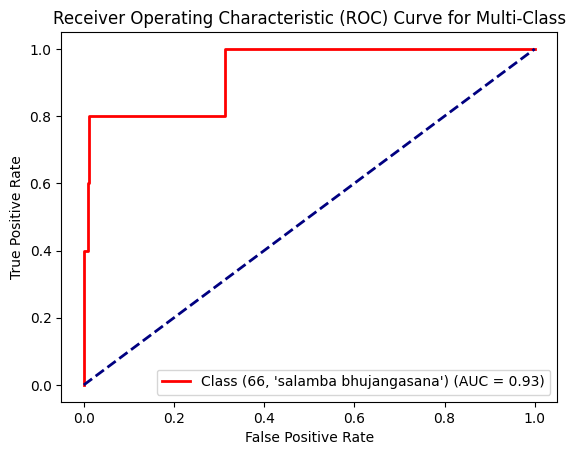

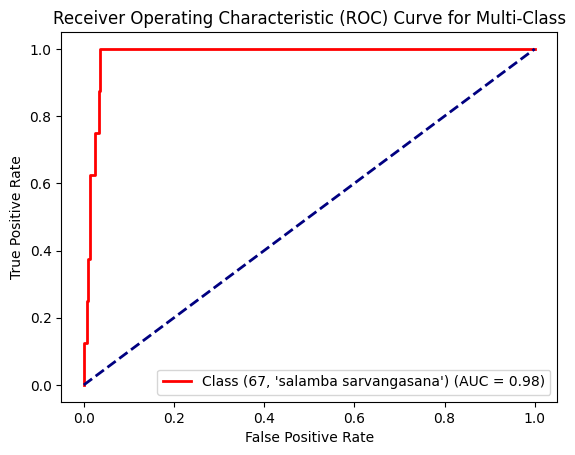

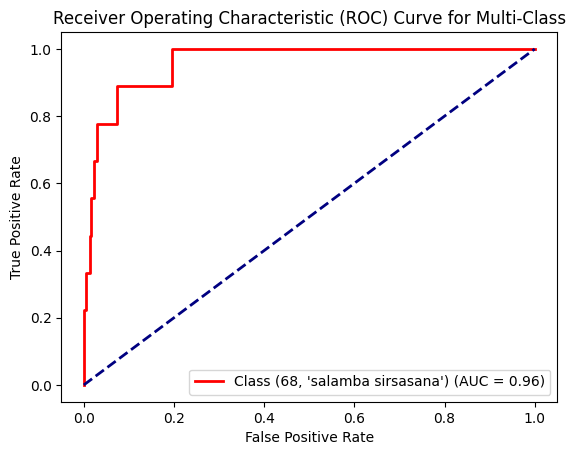

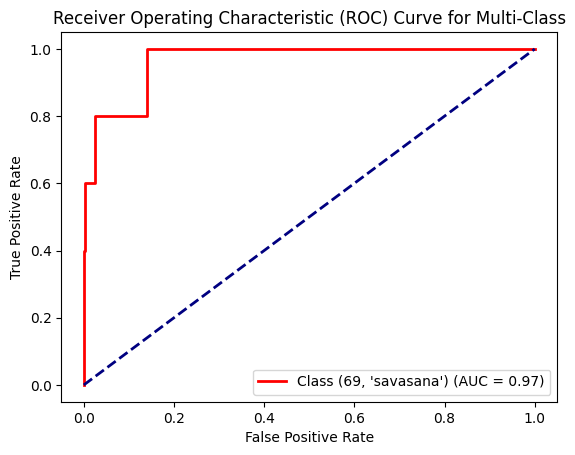

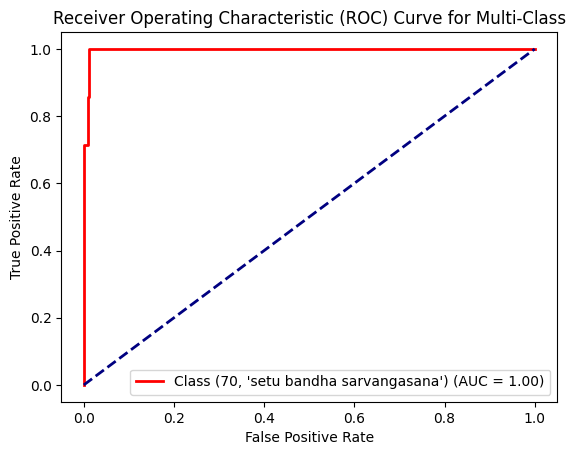

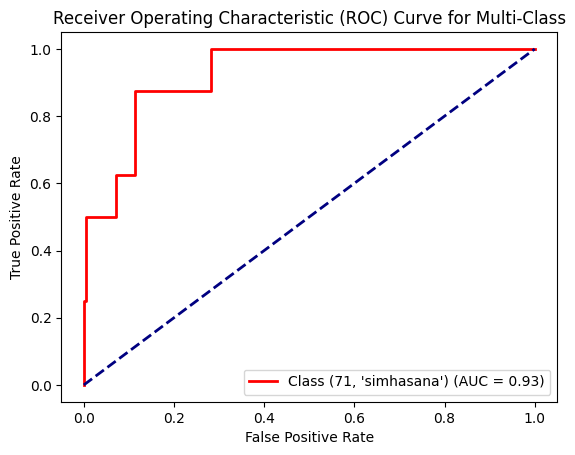

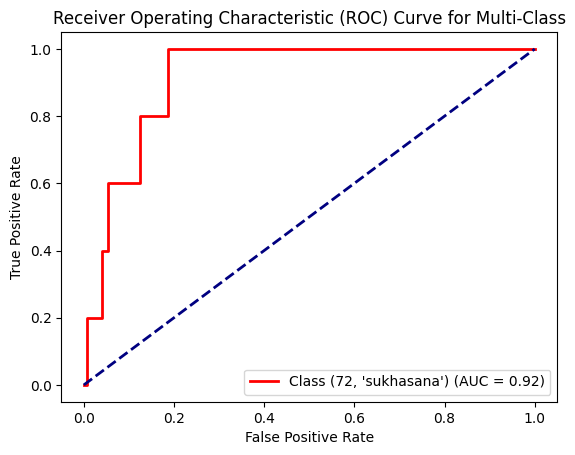

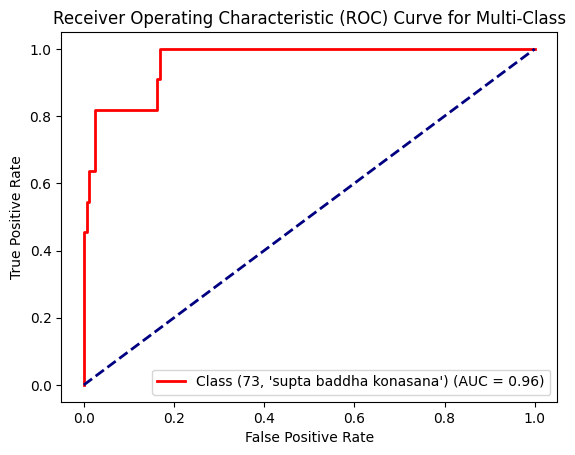

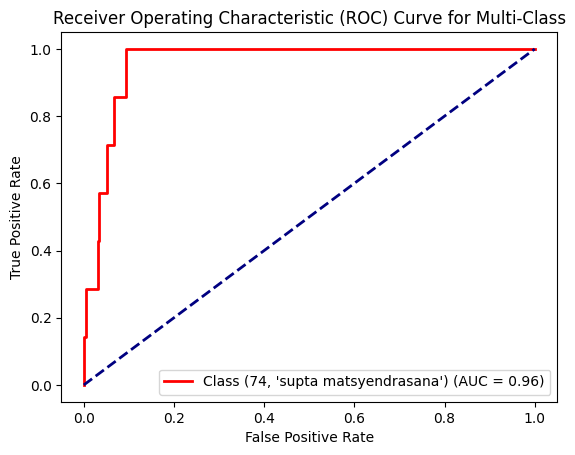

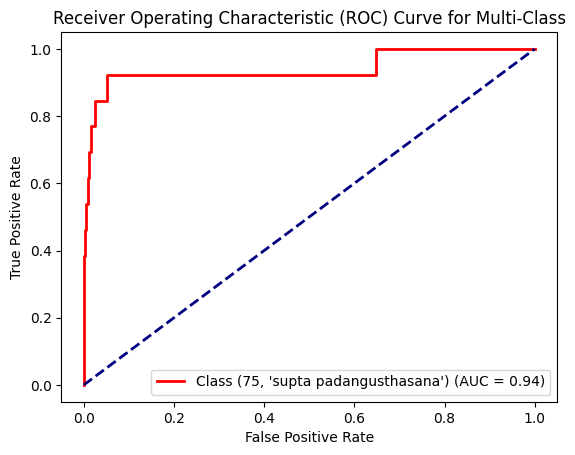

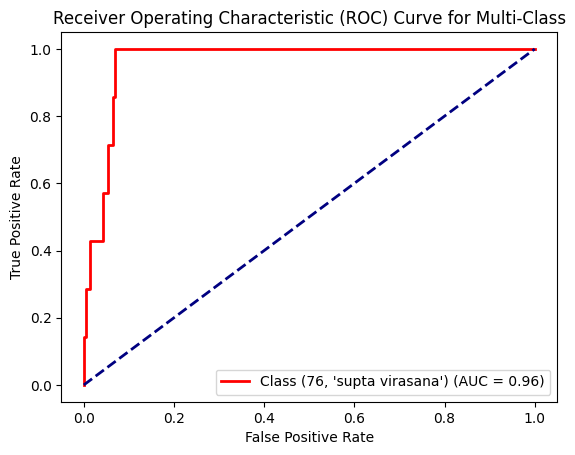

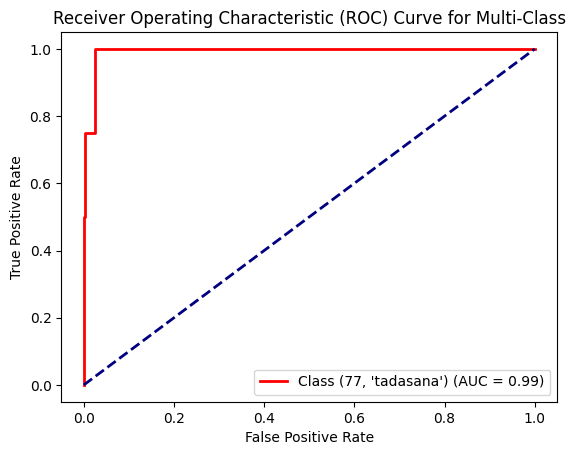

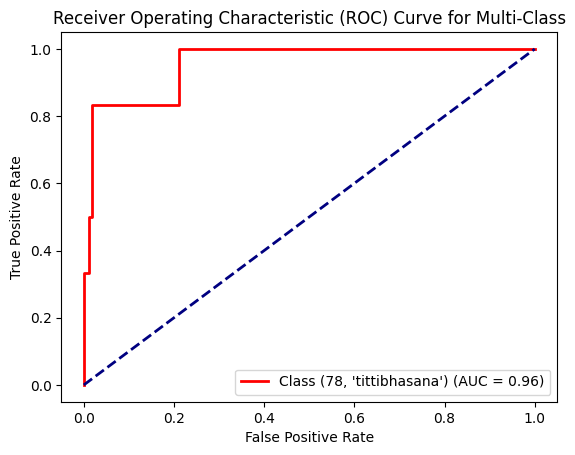

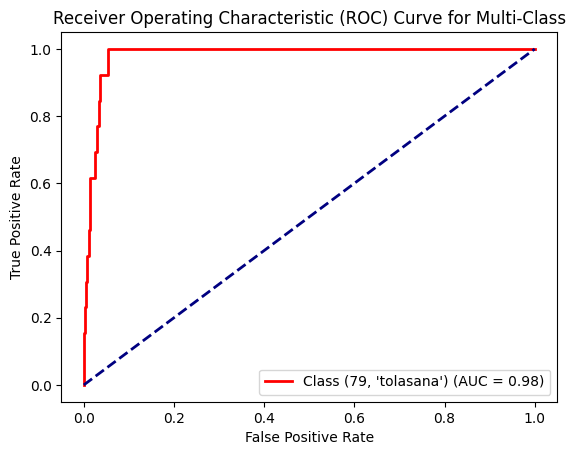

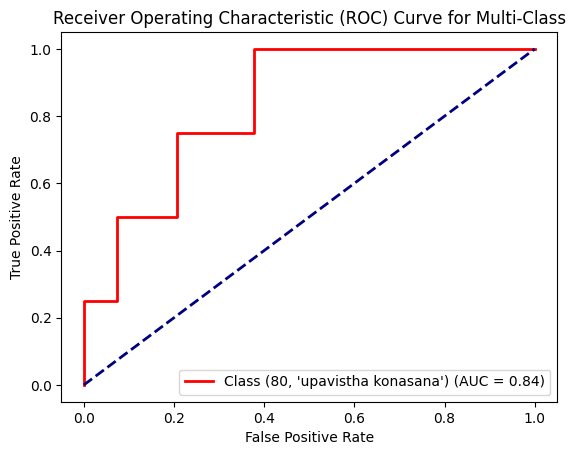

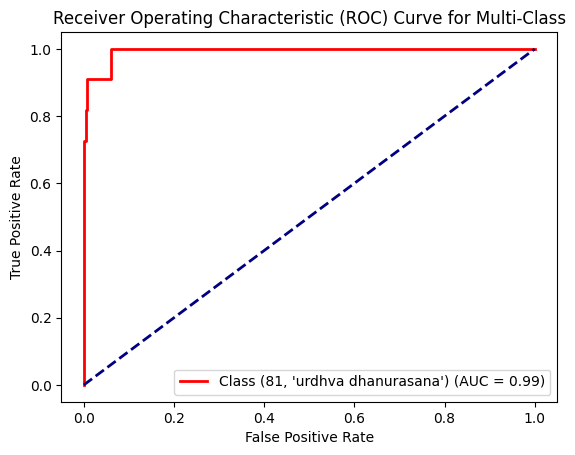

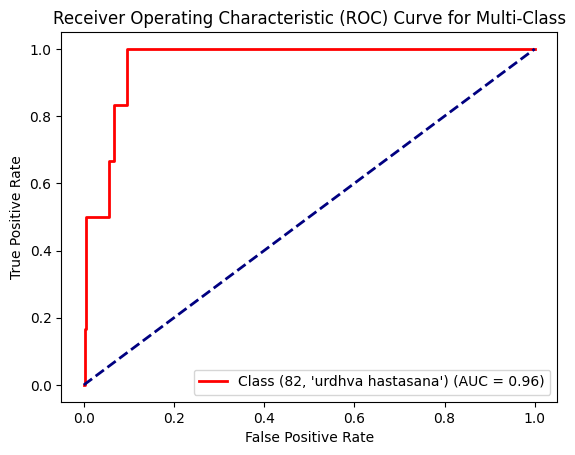

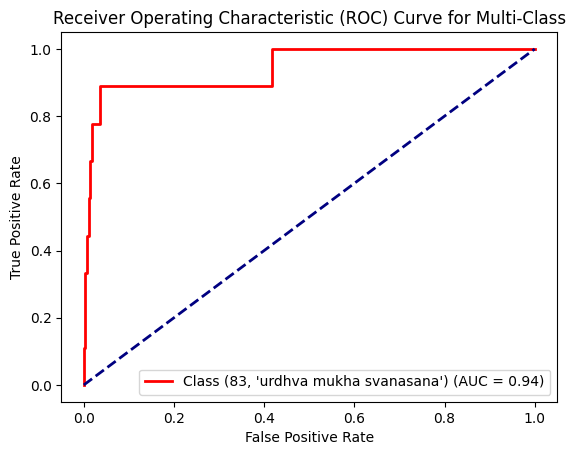

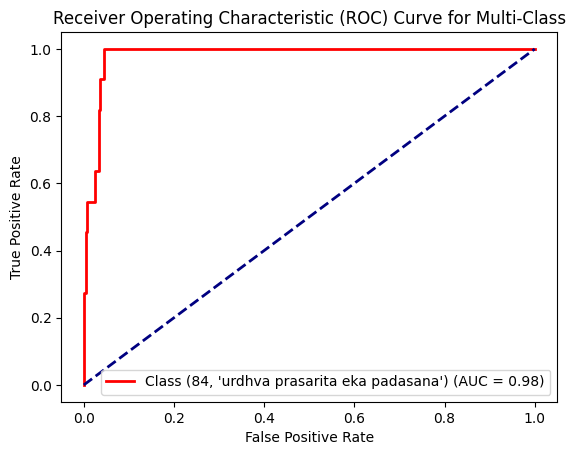

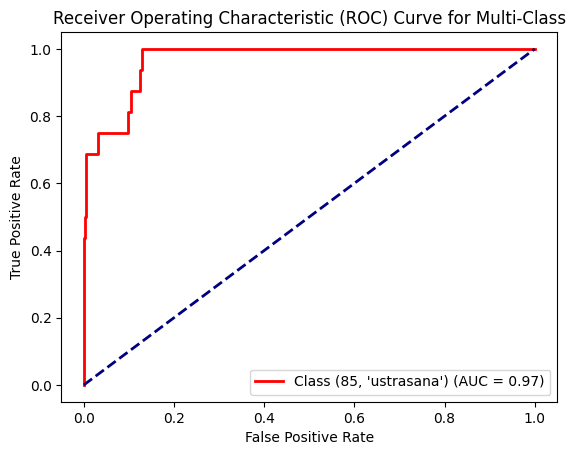

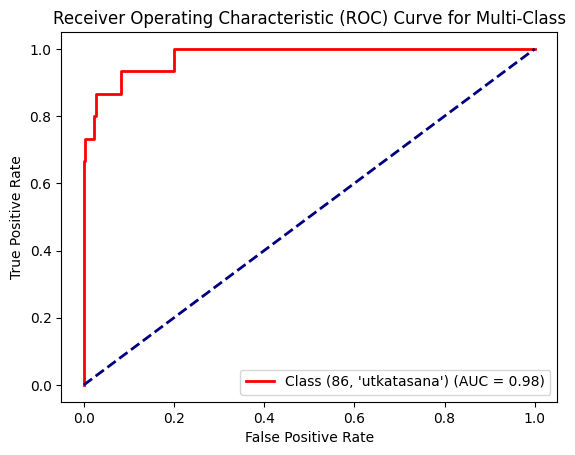

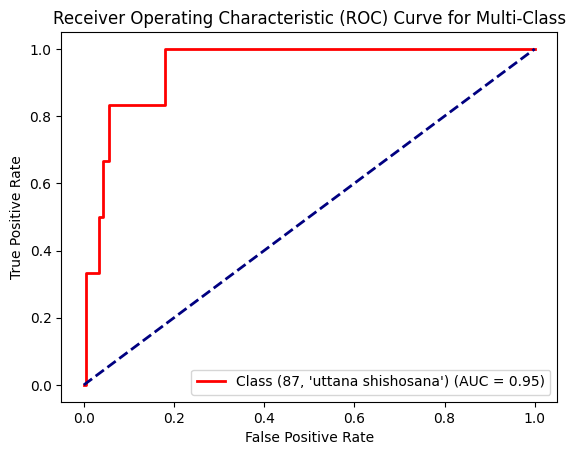

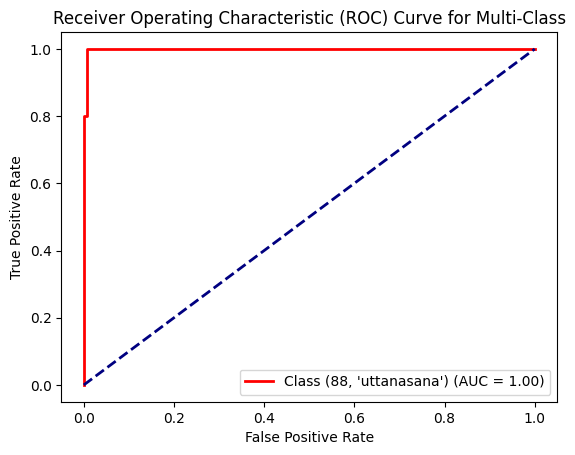

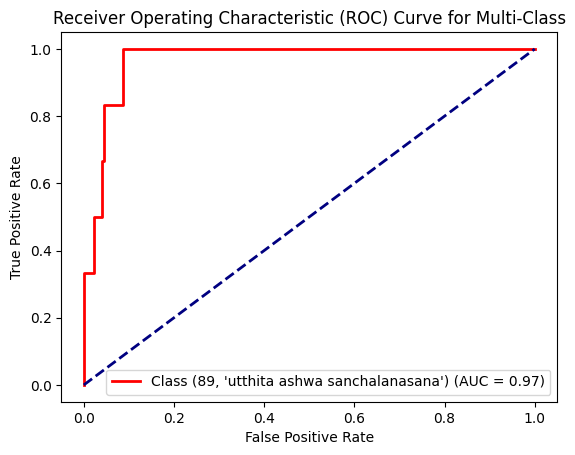

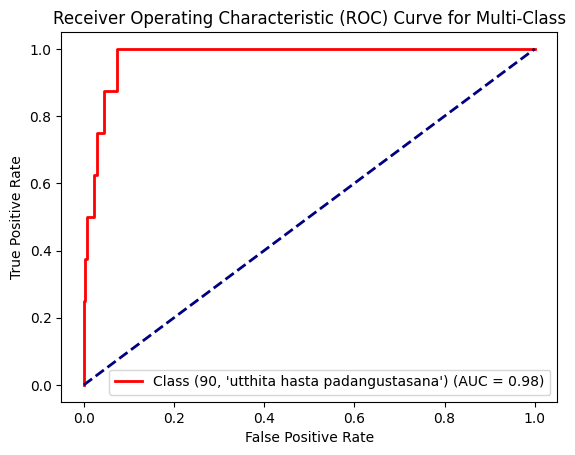

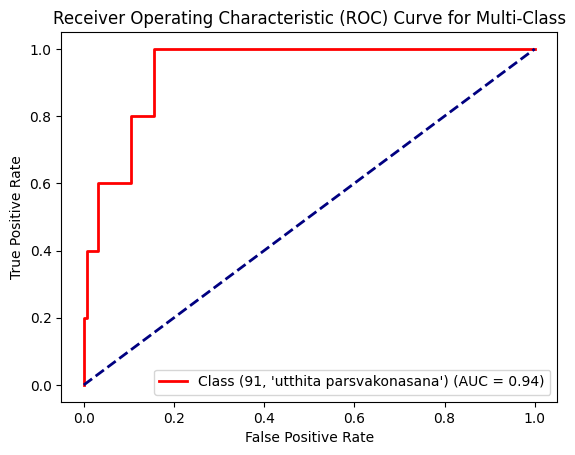

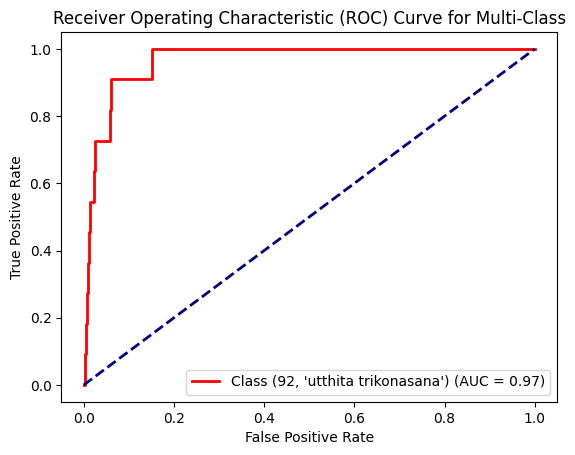

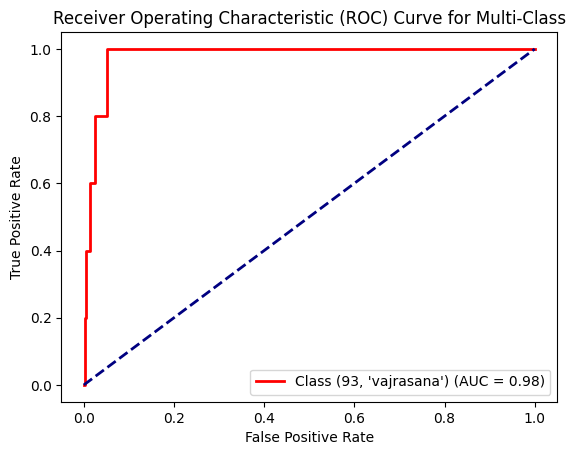

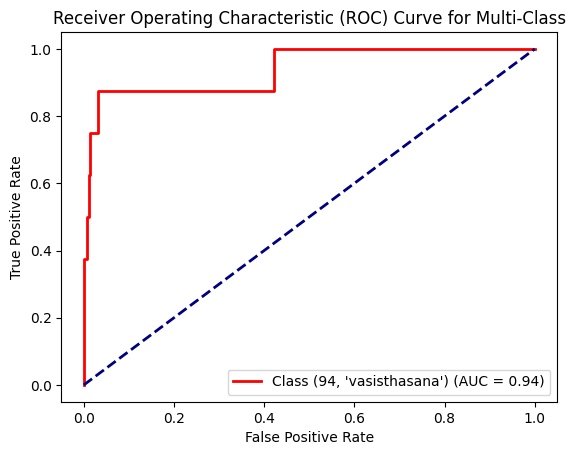

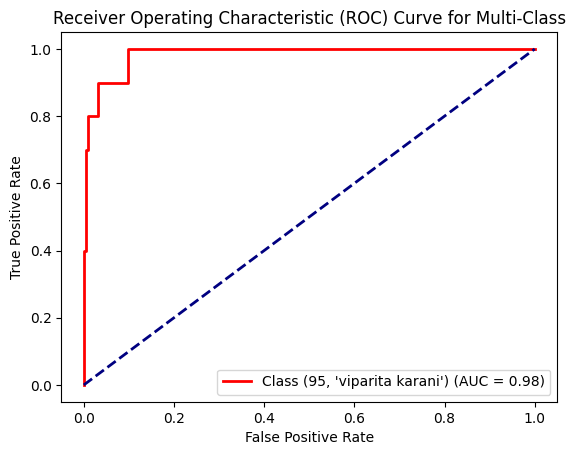

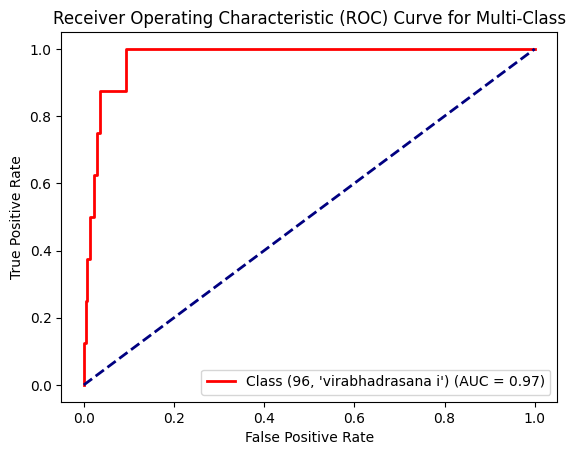

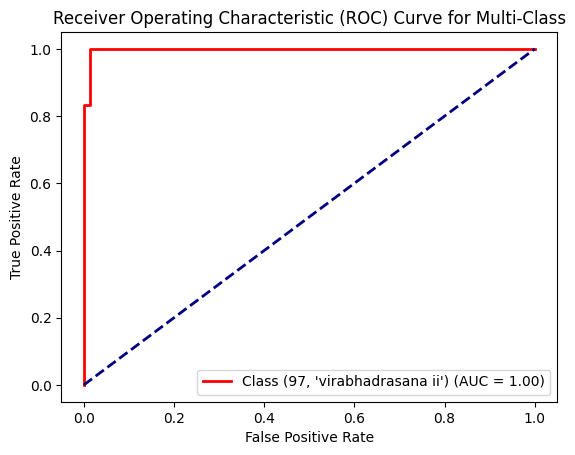

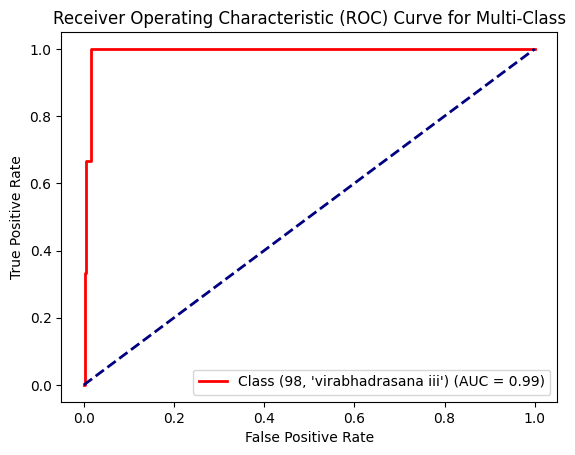

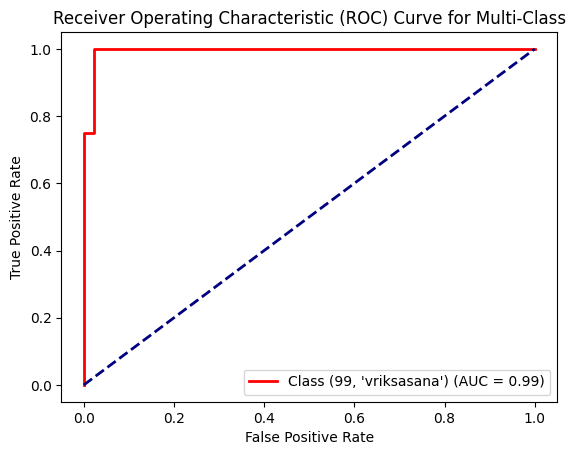

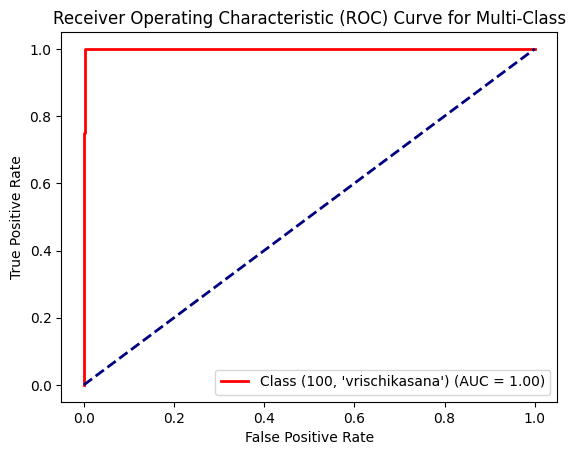

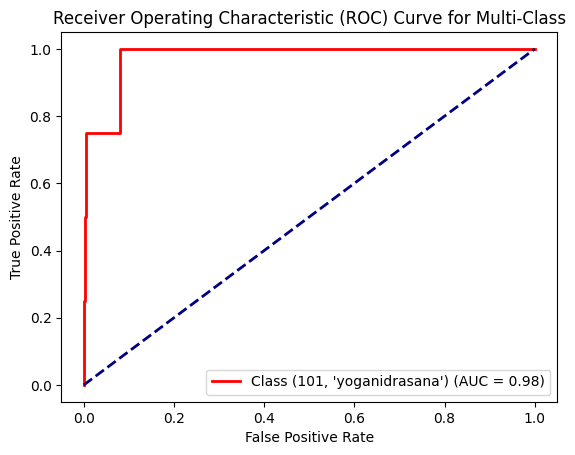

In [19]:
y_true = test_labels_one_hot
y_pred_prob = model.predict(test_data)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 3)) # Add more colors as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color='red', lw=2, label='Class {0} (AUC = {1:0.2f})'.format((i,labels_dict2[i]), roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
pred_labels = np.argmax(y_pred_prob, axis=1)
test_labels = np.argmax(test_labels_one_hot, axis=1)

24/24 [==============================] - 5s 189ms/step


In [28]:
pred_labels_list = list(pred_labels)
test_labels_list = list(test_labels)

In [35]:
Column1 = []
Column2 = []
for i in range(len(pred_labels_list)):
    if pred_labels_list[i]!=test_labels_list[i]:
        Column1.append(labels_dict2[pred_labels_list[i]])
        Column2.append(labels_dict2[test_labels_list[i]])

In [49]:
wrong = pd.DataFrame( {"Predicted_Position":Column1,"True_Position":Column2})
wrong.sort_values(by=["Predicted_Position"],inplace=True,ignore_index=True)
print(wrong["Predicted_Position"].value_counts().to_string())

Predicted_Position
agnistambhasana                  23
supta baddha konasana            18
natarajasana                     16
bharadvajasana i                 15
adho mukha svanasana             13
utthita trikonasana              13
ustrasana                        12
paschimottanasana                12
sukhasana                        11
chaturanga dandasana             11
bitilasana                       11
utthita parsvakonasana           10
garudasana                       10
tolasana                          9
salamba sarvangasana              9
parighasana                       9
urdhva prasarita eka padasana     8
eka pada rajakapotasana           8
urdhva mukha svanasana            8
ananda balasana                   8
bhujangasana                      7
parsva bakasana                   7
virabhadrasana i                  7
padmasana                         6
parivrtta janu sirsasana          6
astavakrasana                     6
supta padangusthasana             5
dandasana

##### 2

24/24 [==============================] - 9s 202ms/step


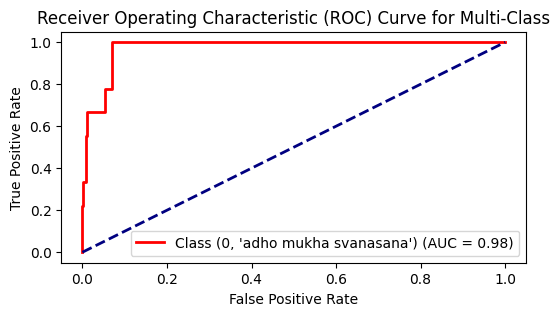

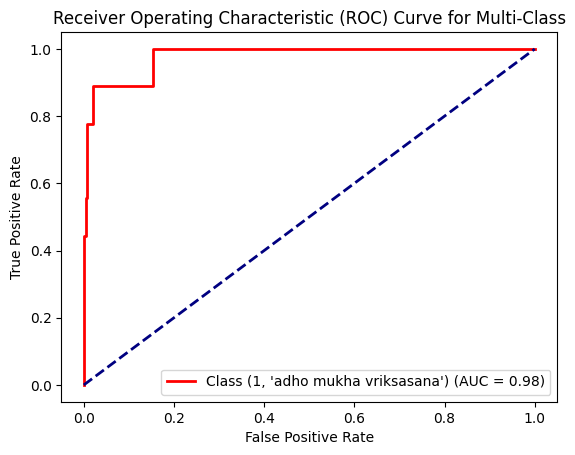

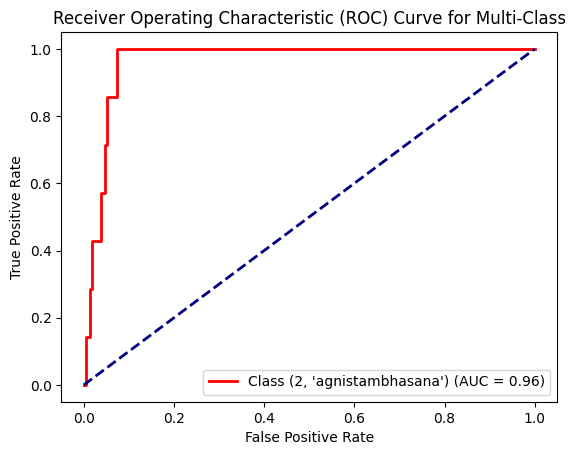

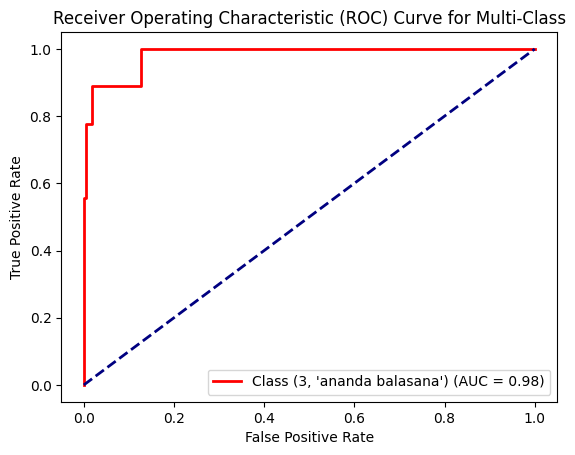

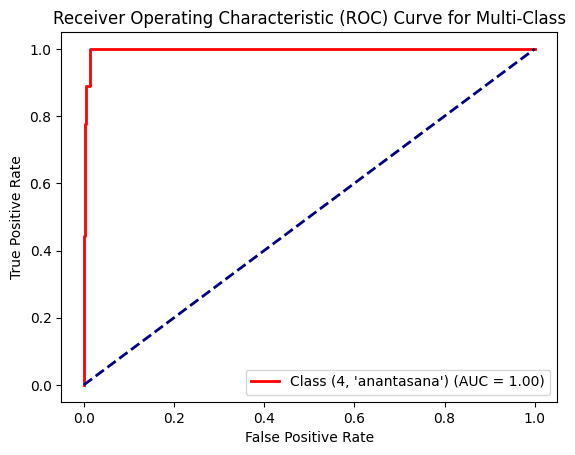

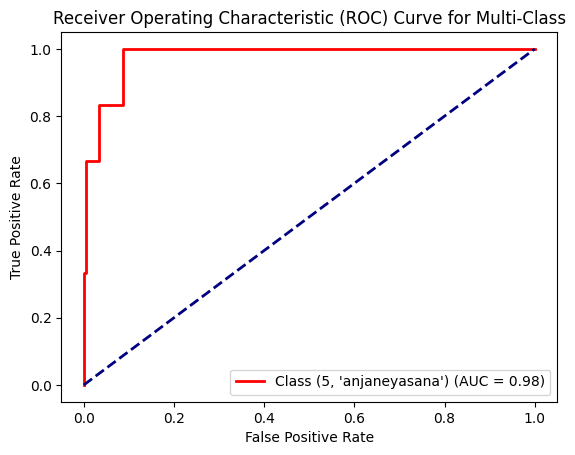

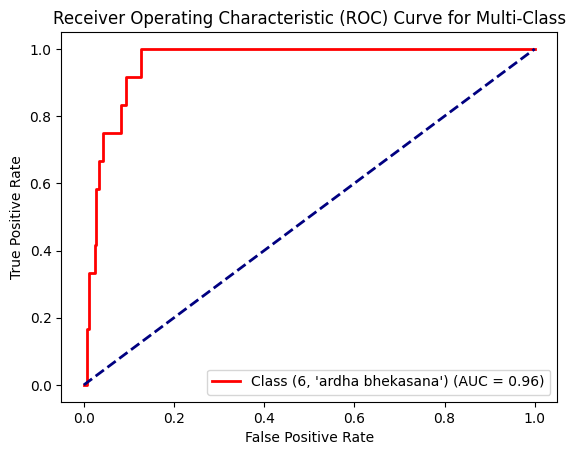

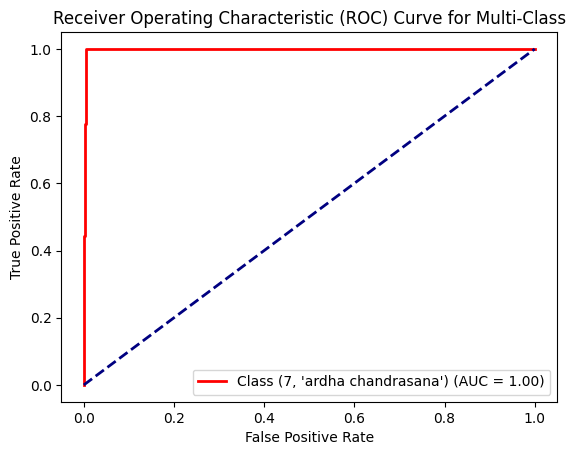

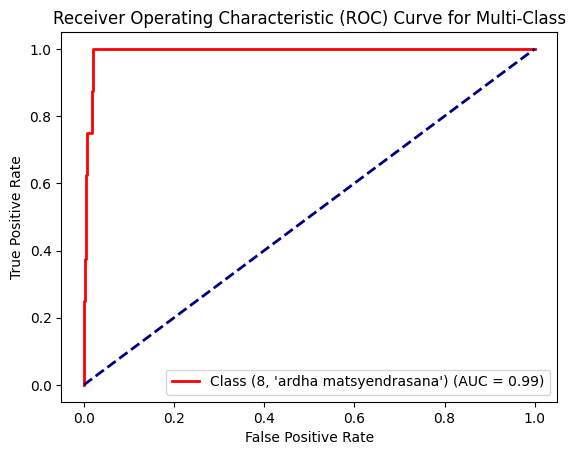

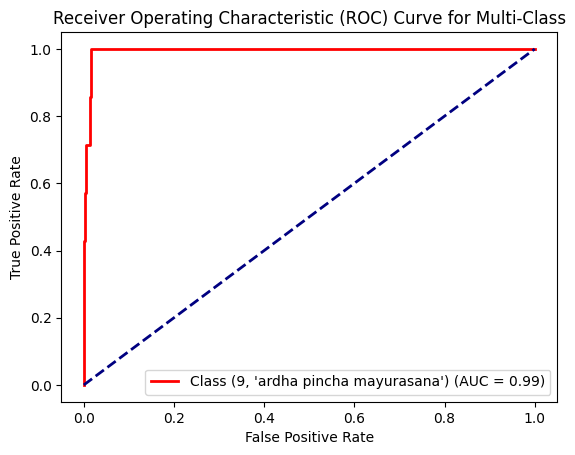

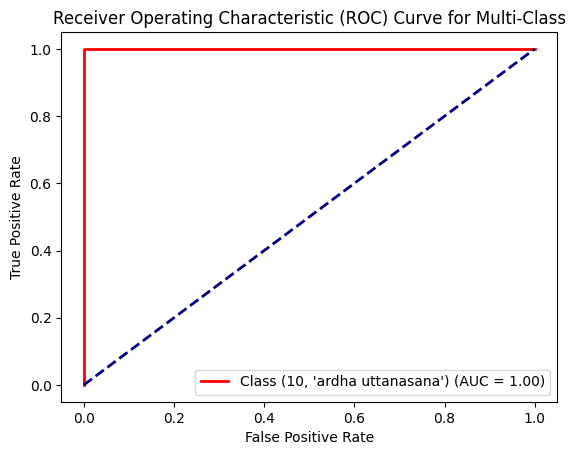

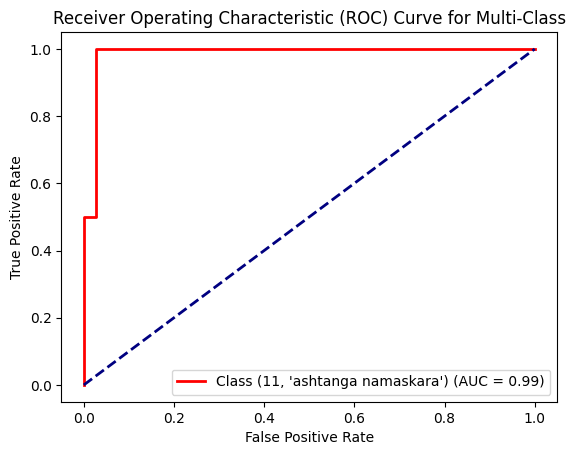

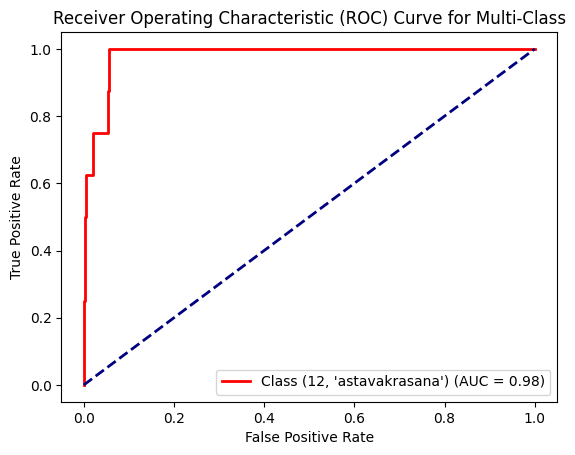

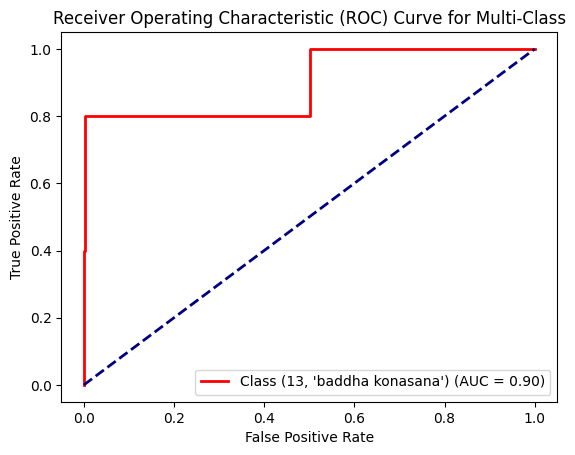

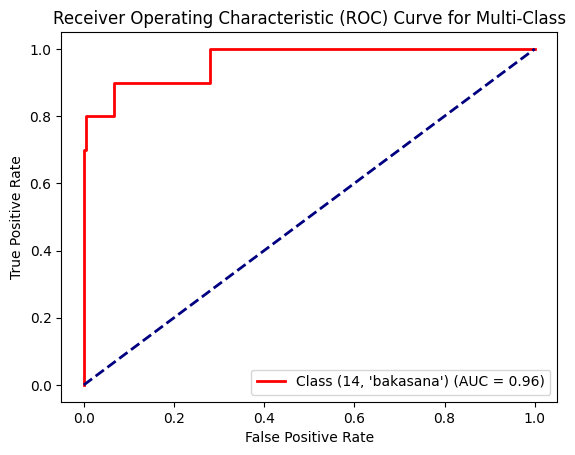

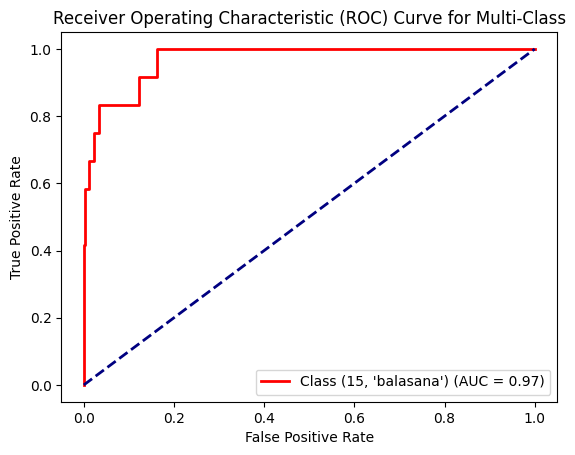

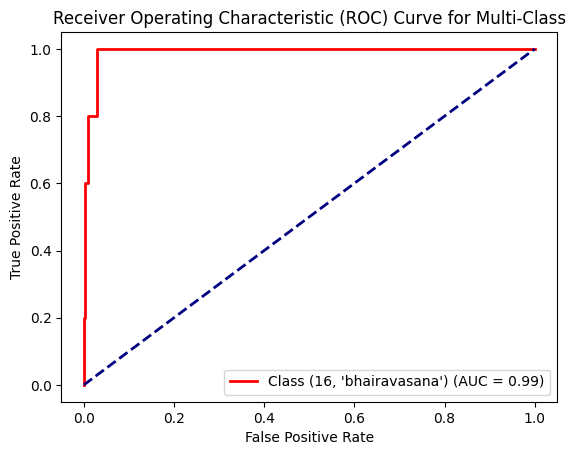

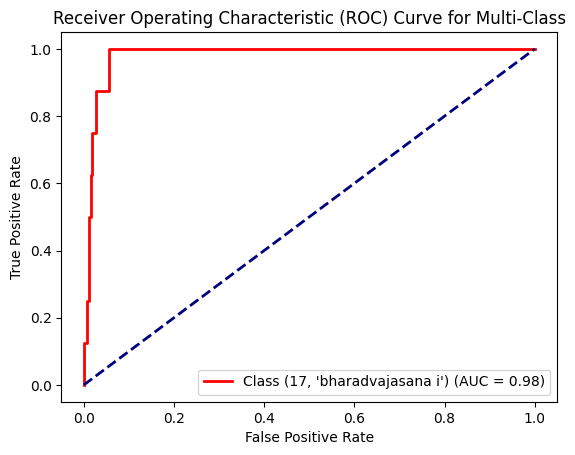

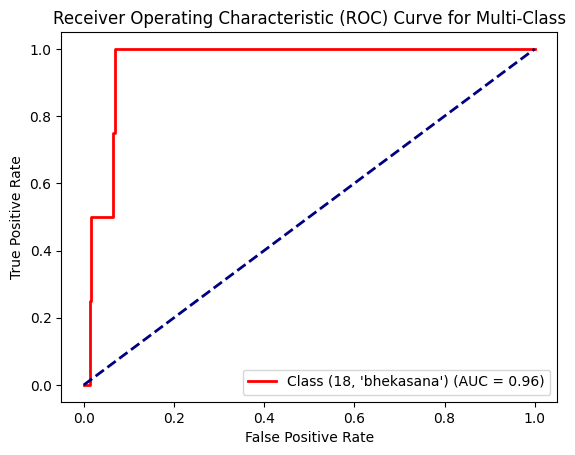

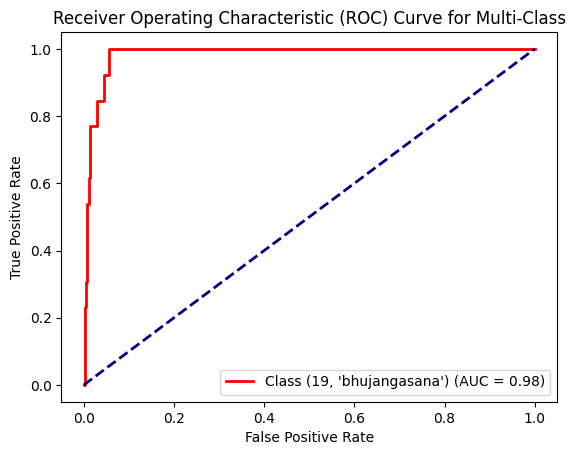

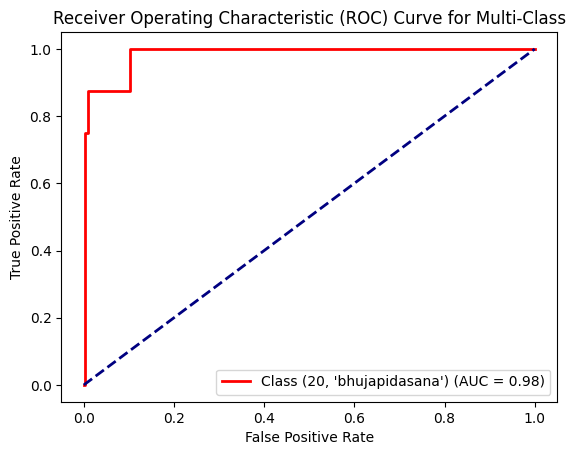

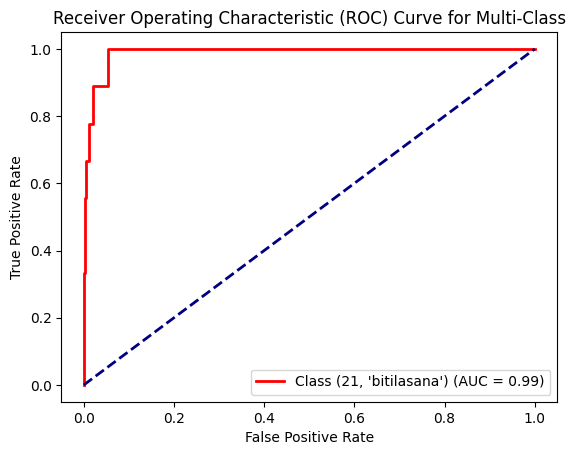

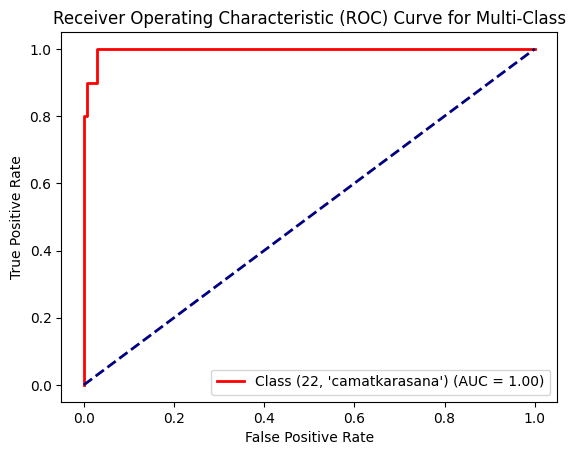

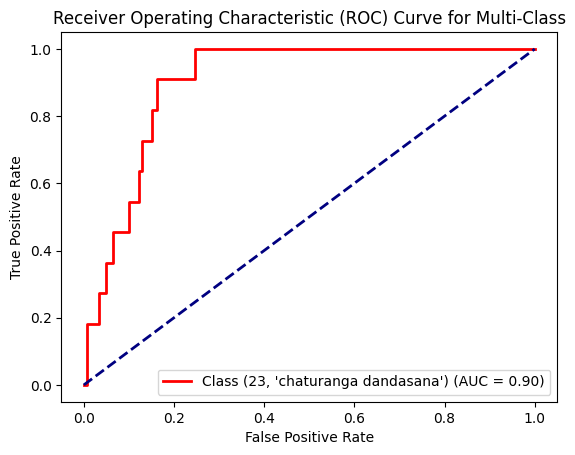

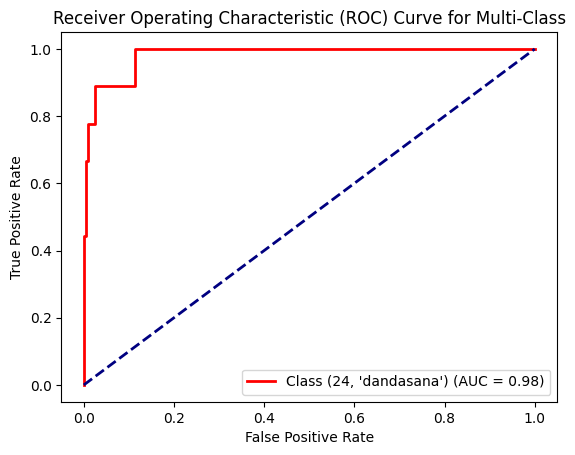

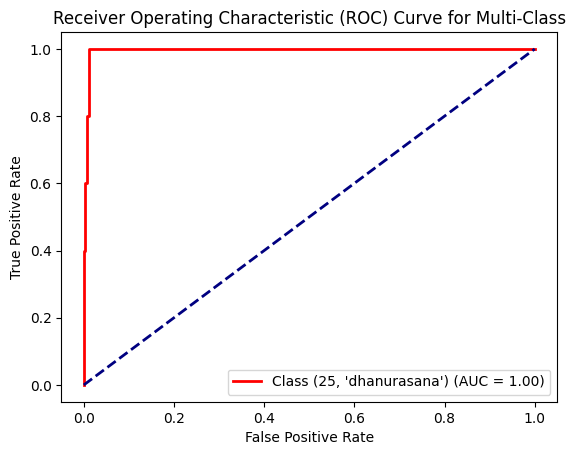

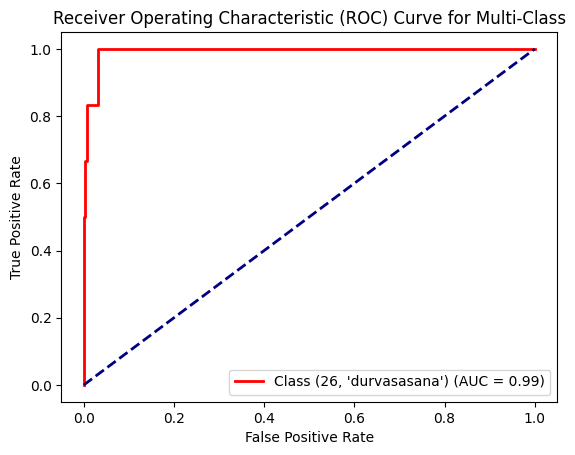

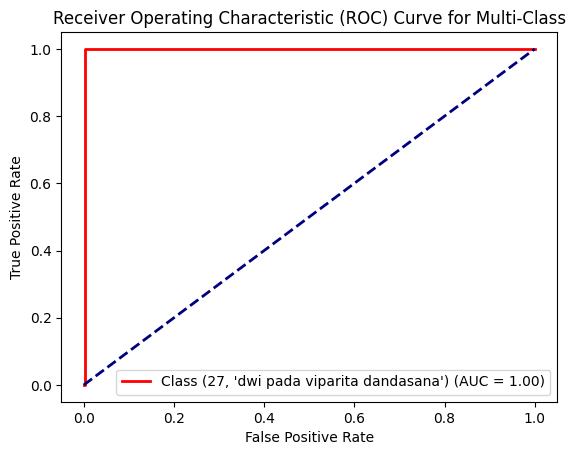

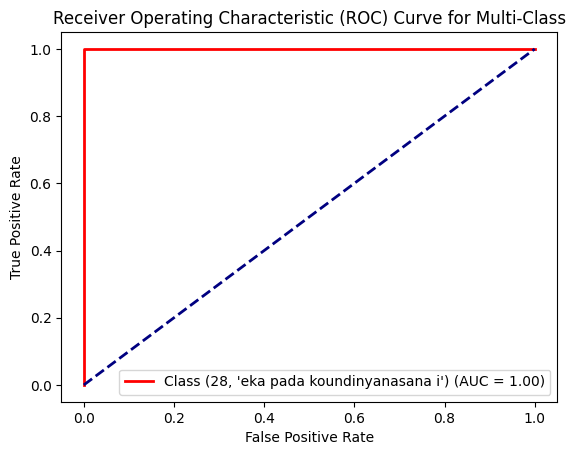

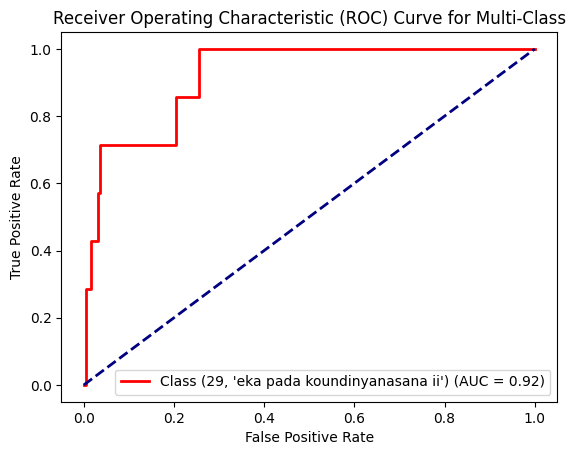

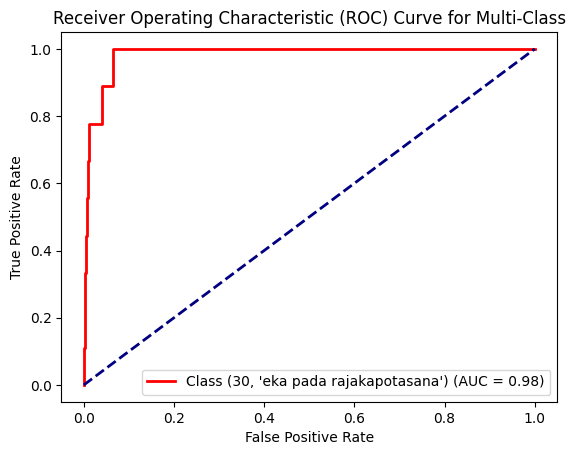

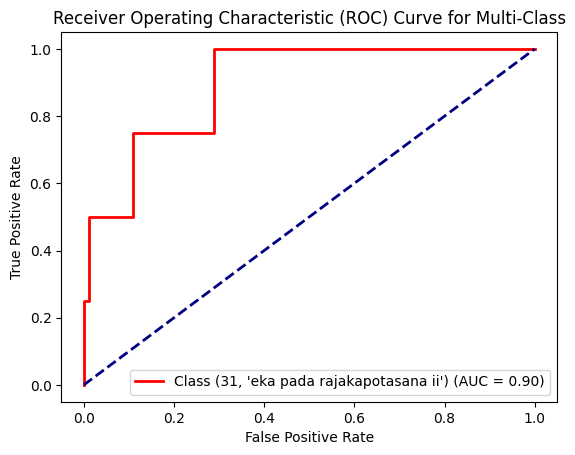

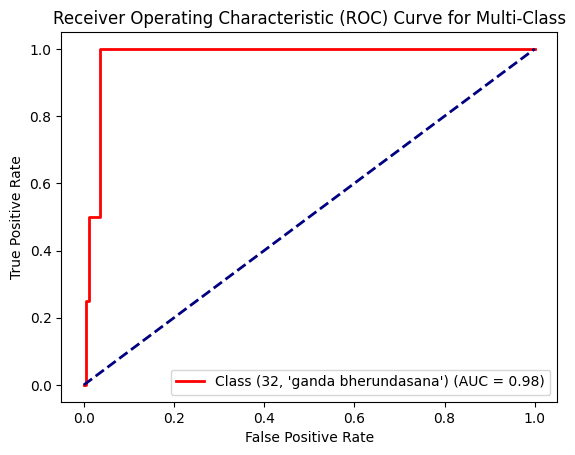

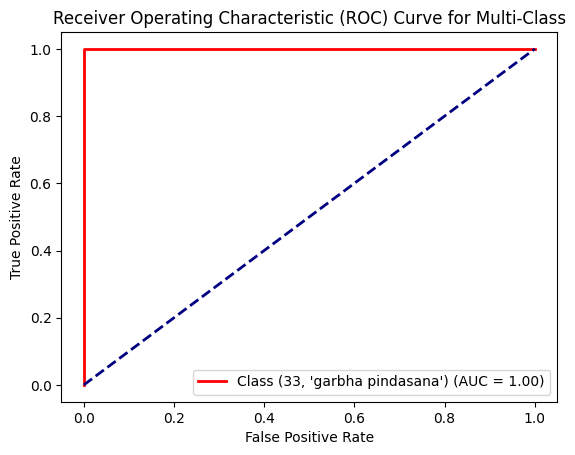

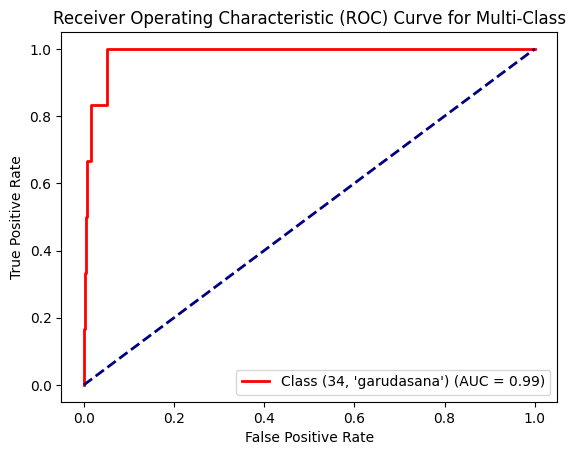

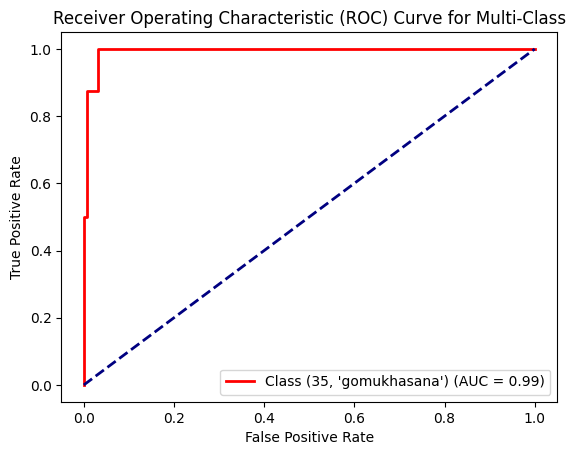

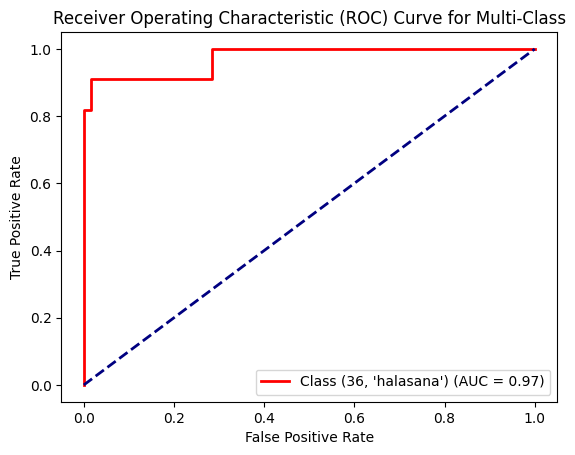

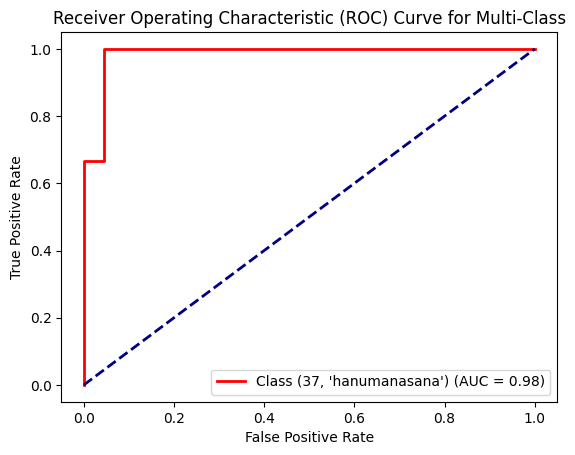

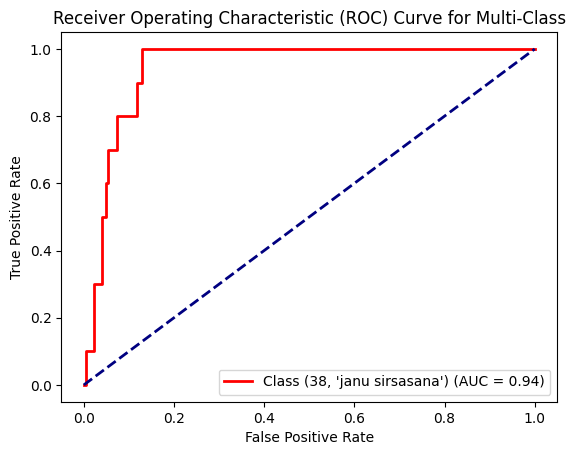

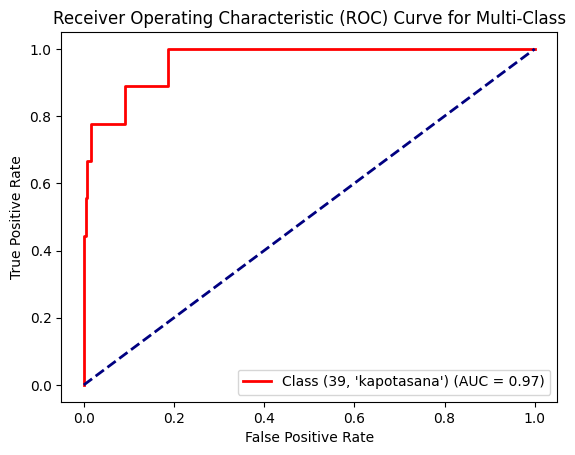

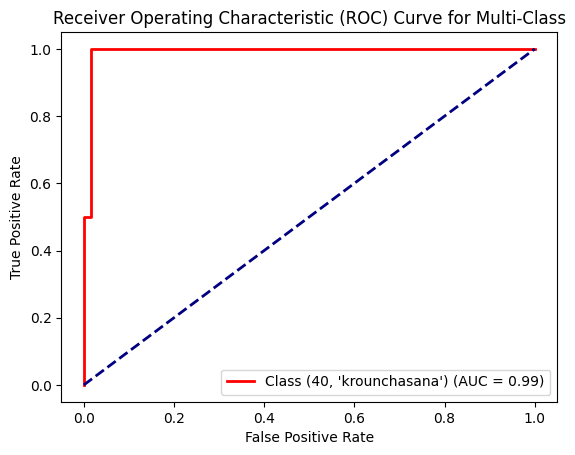

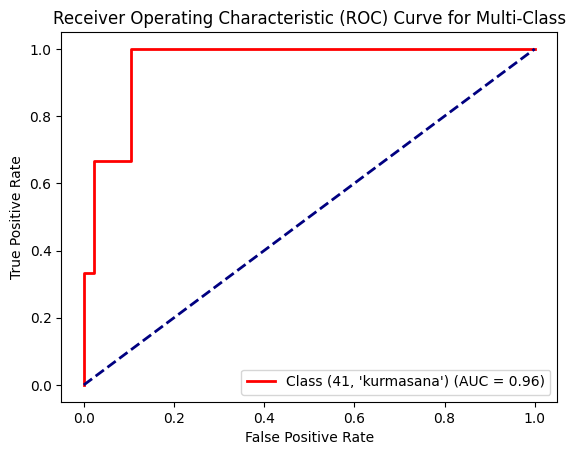

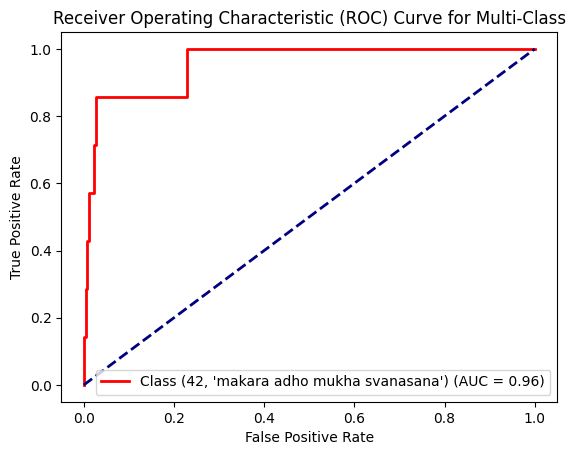

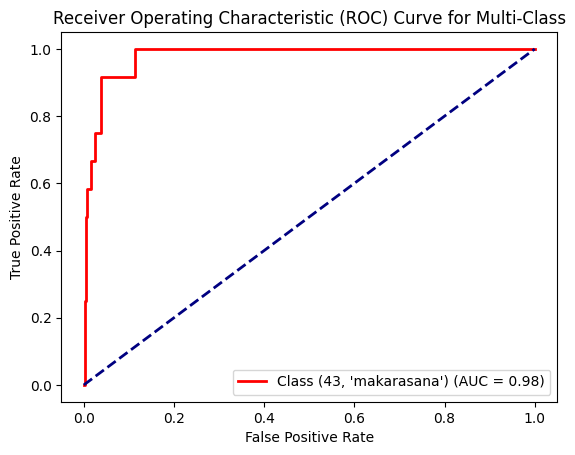

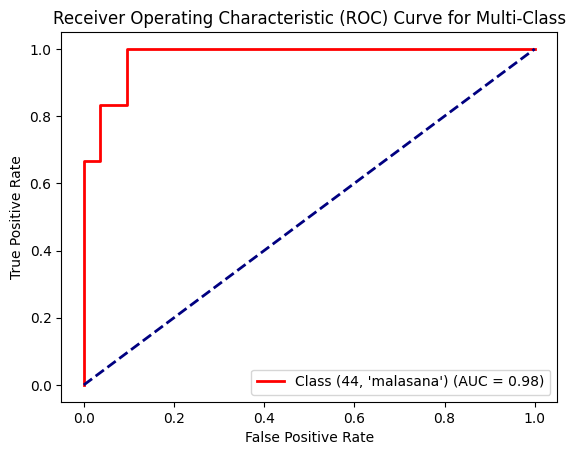

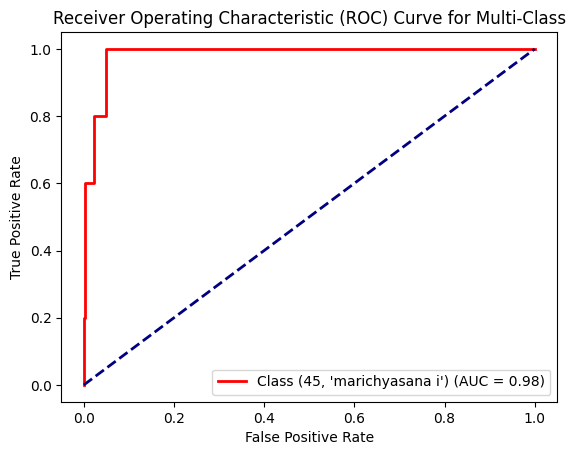

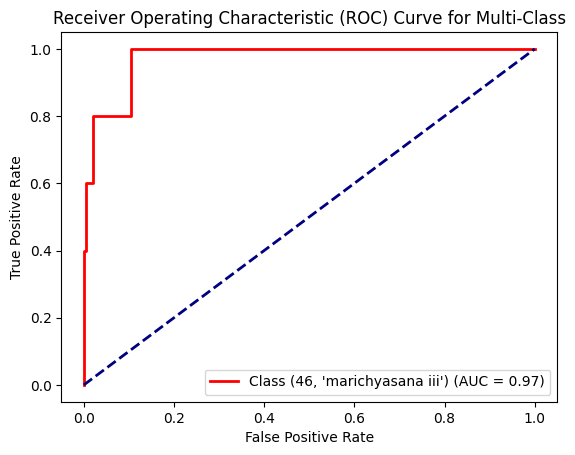

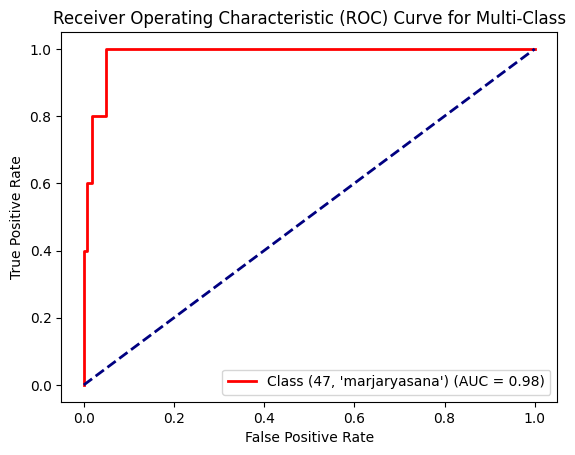

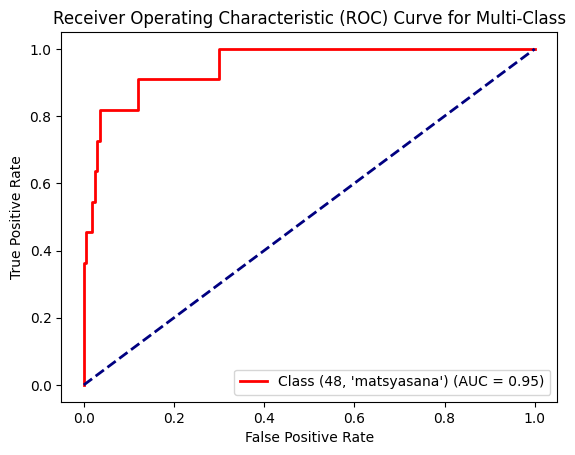

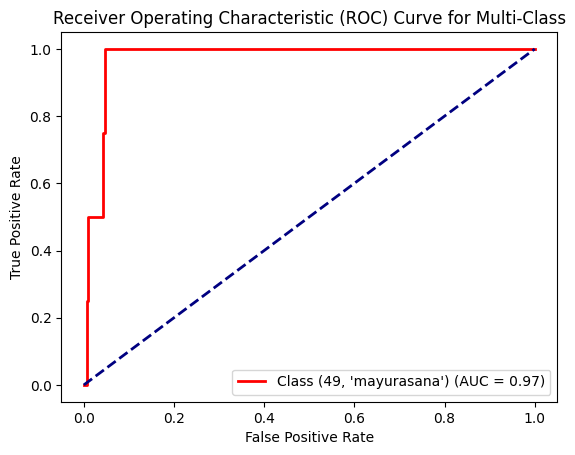

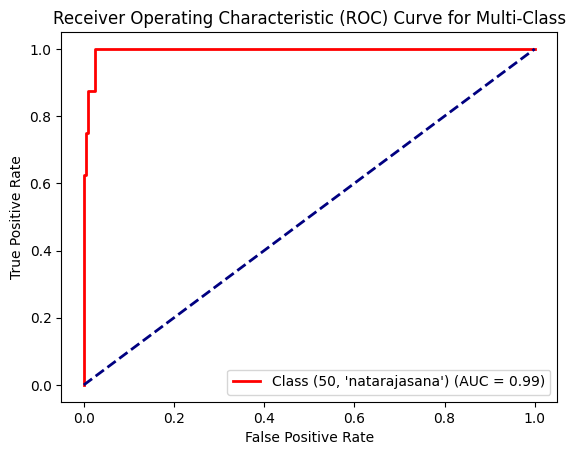

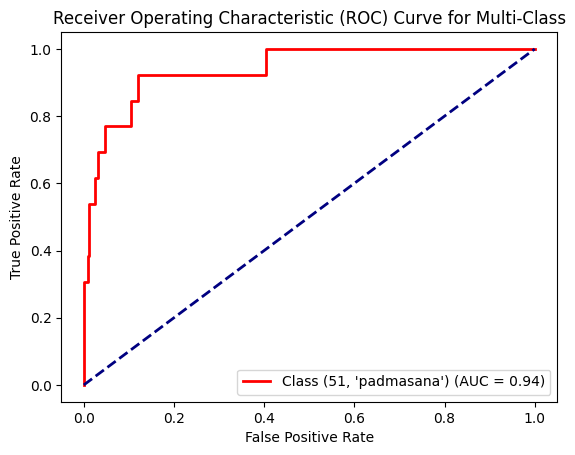

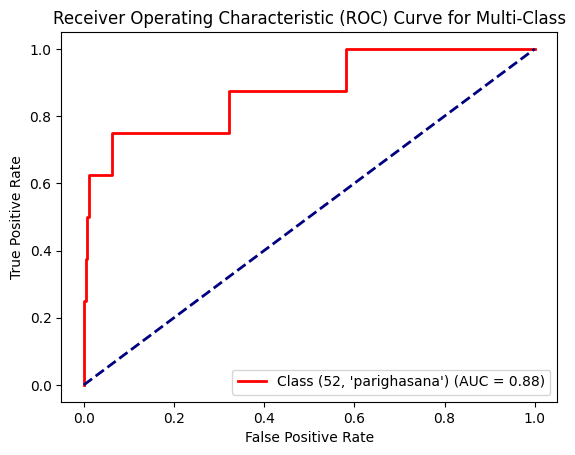

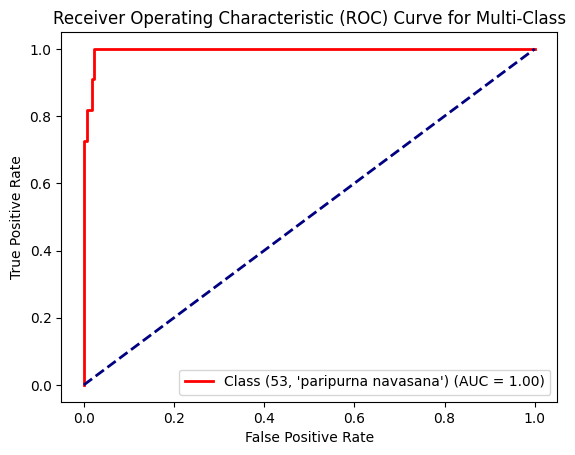

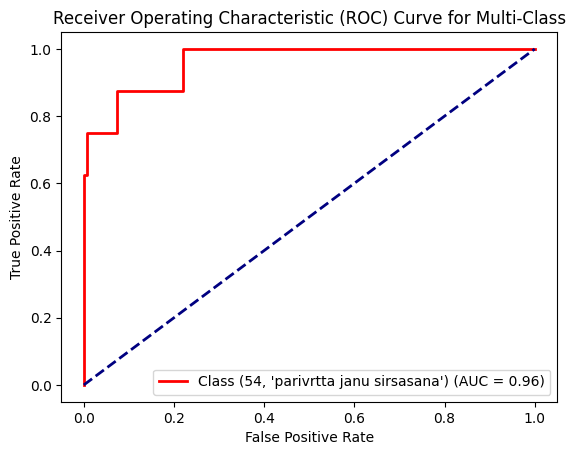

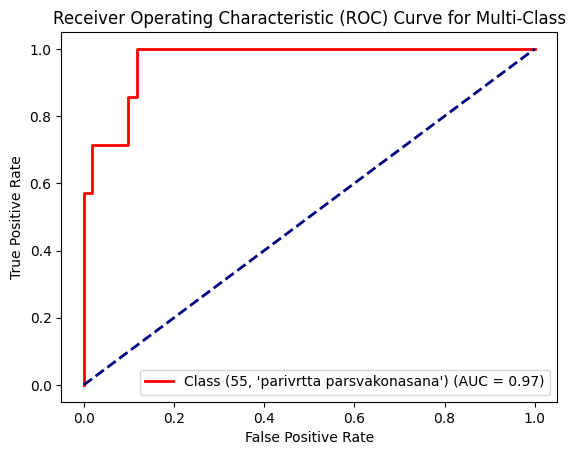

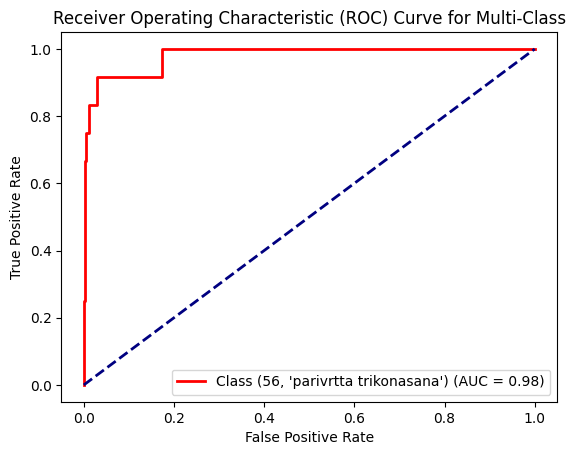

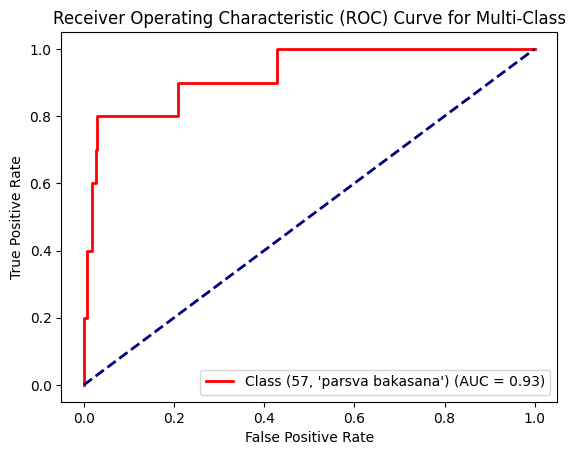

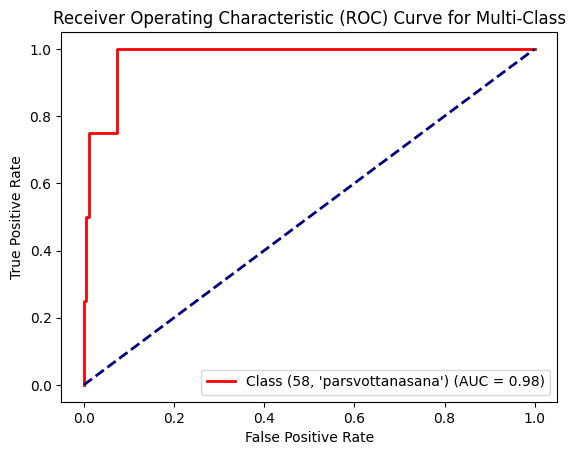

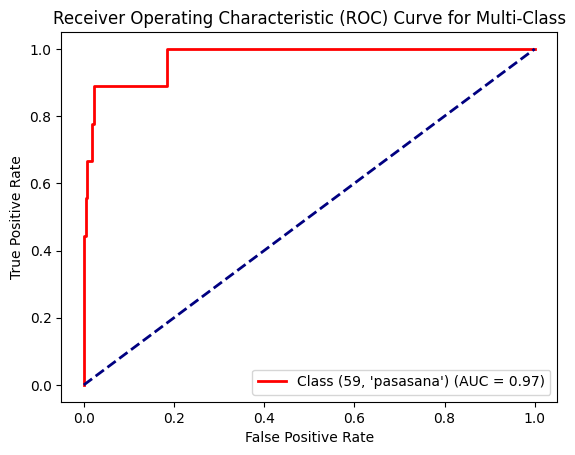

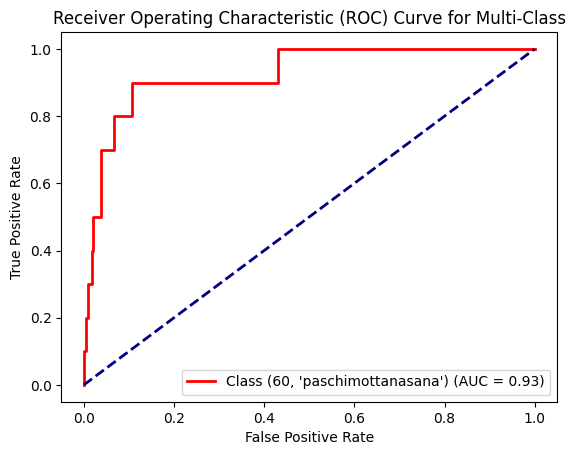

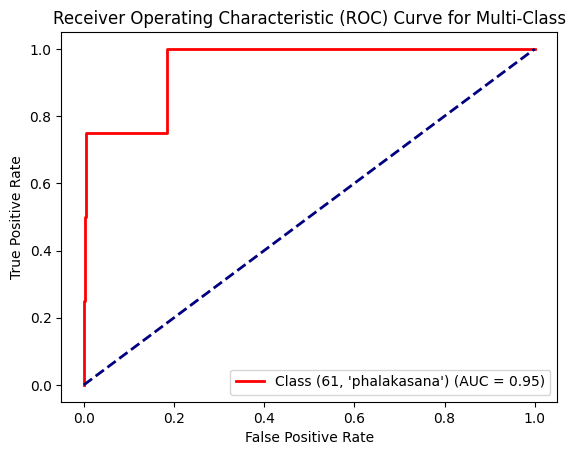

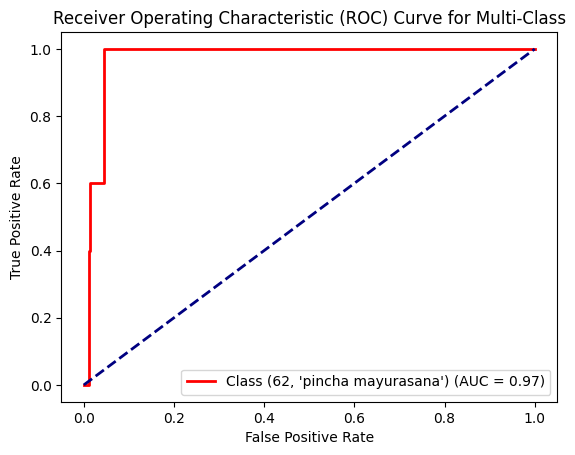

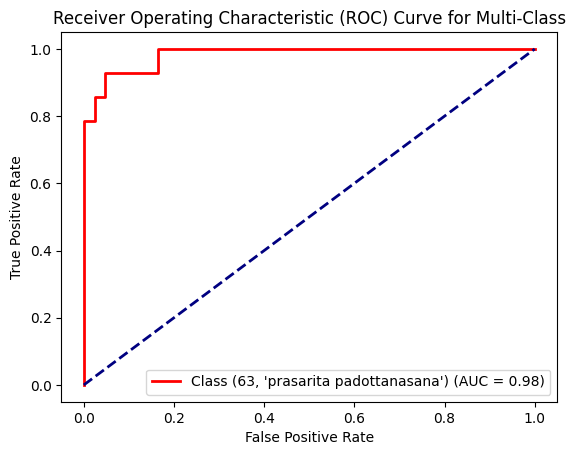

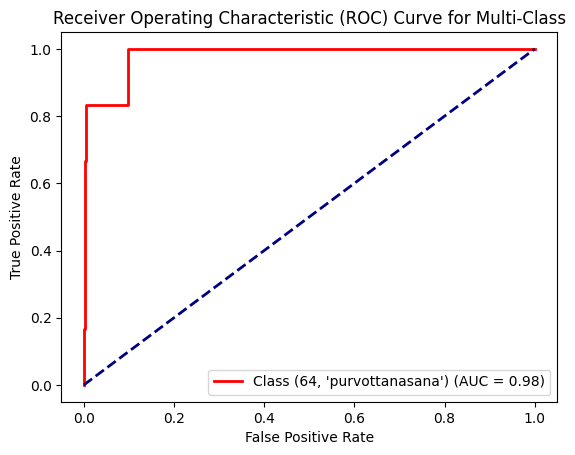

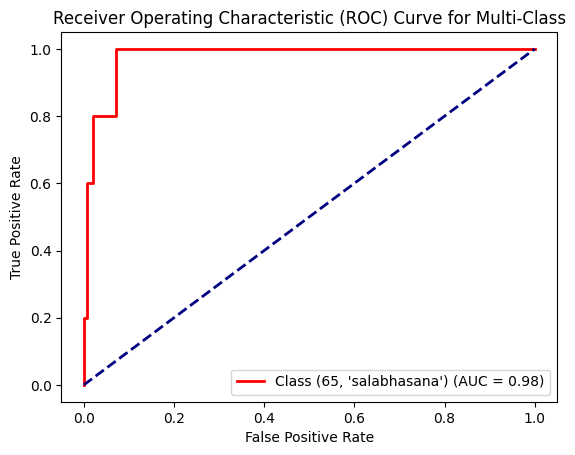

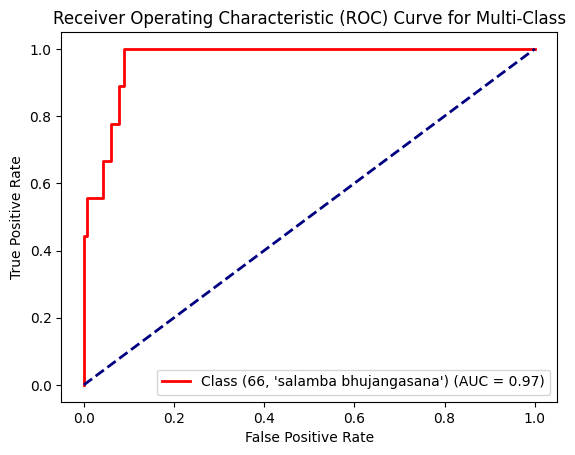

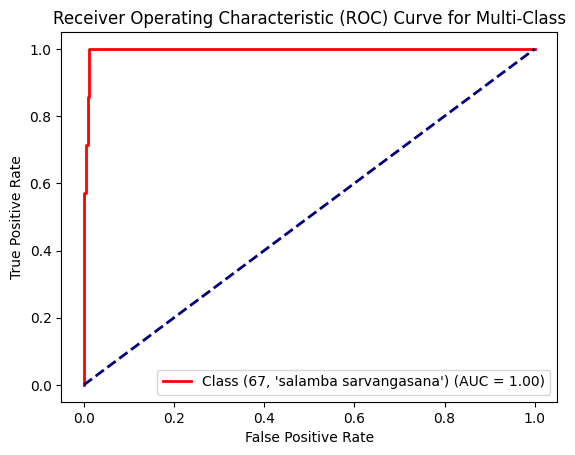

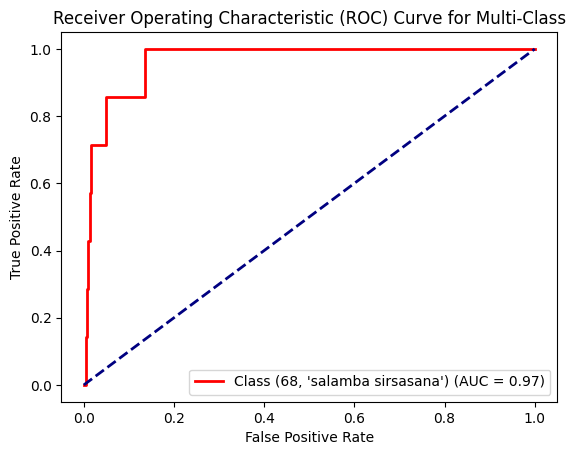

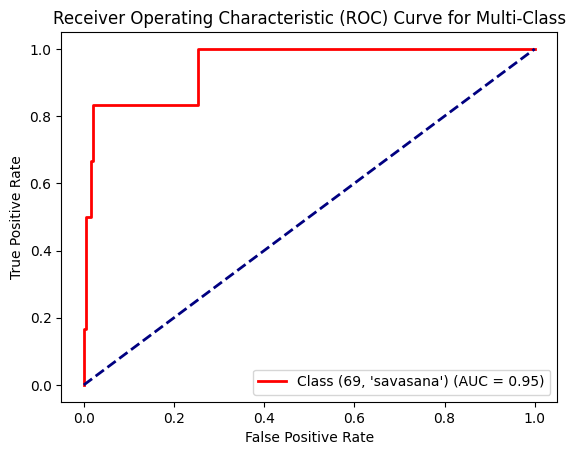

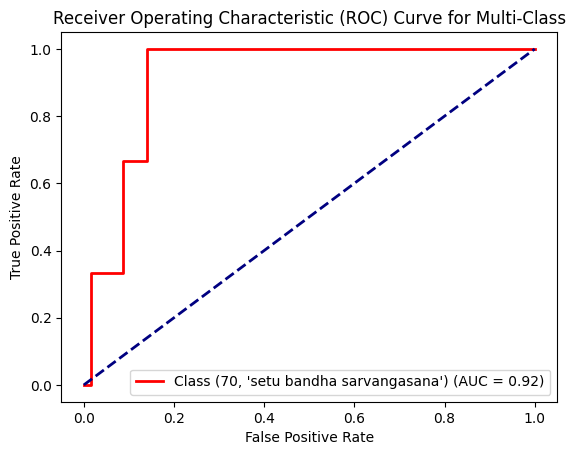

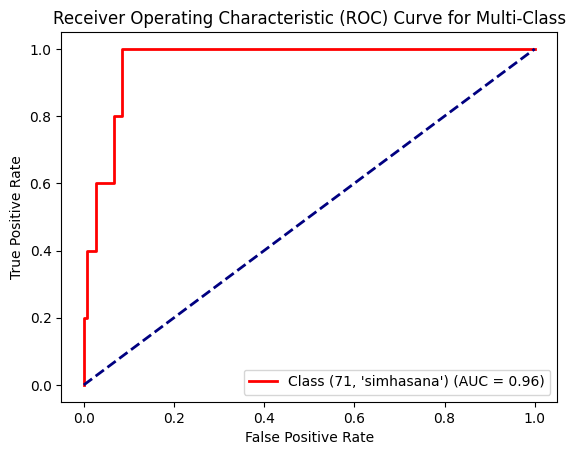

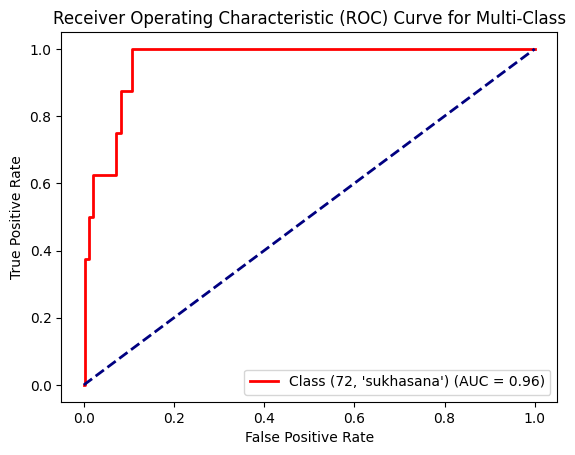

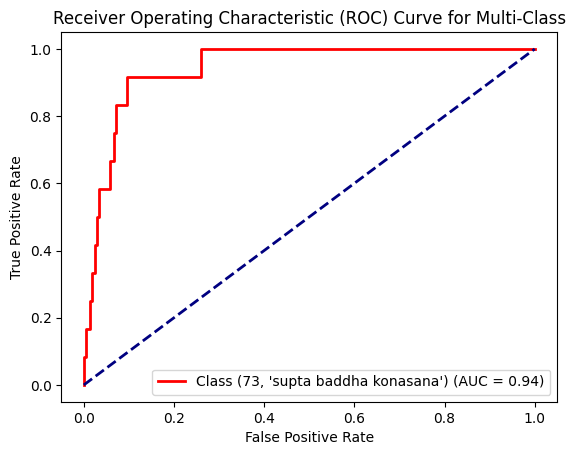

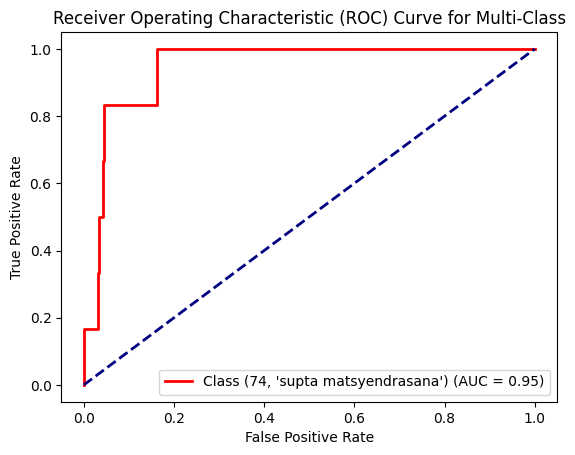

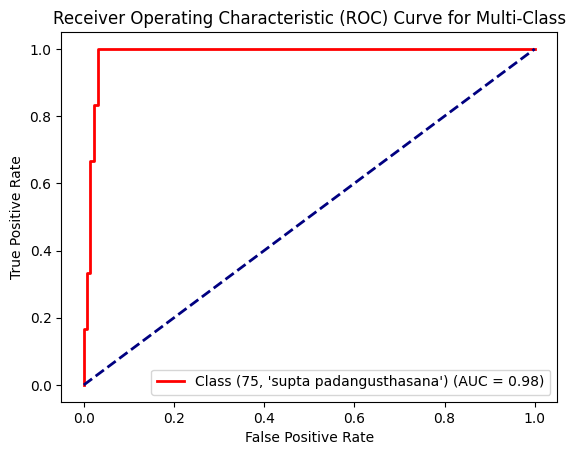

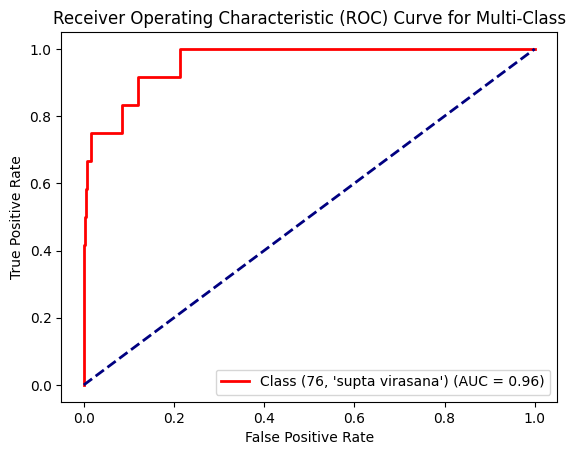

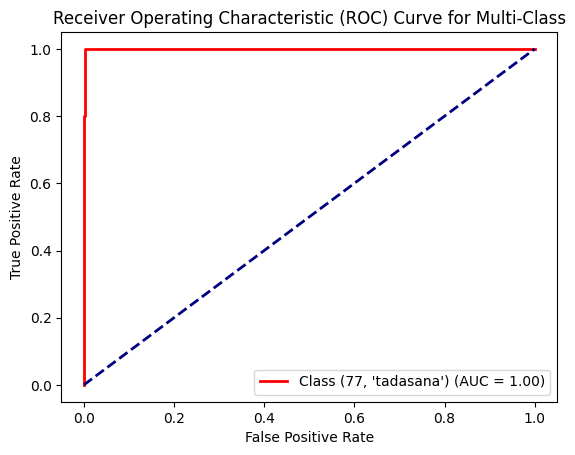

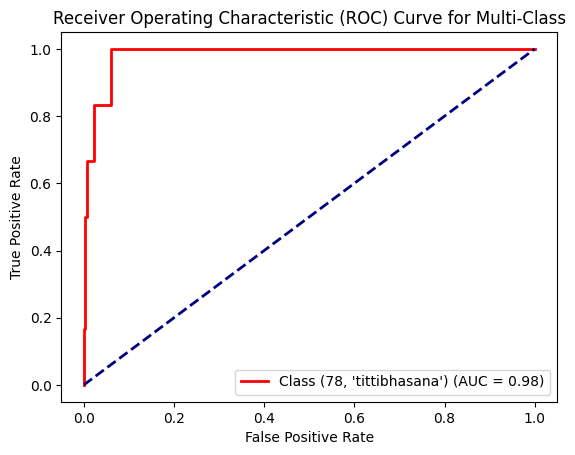

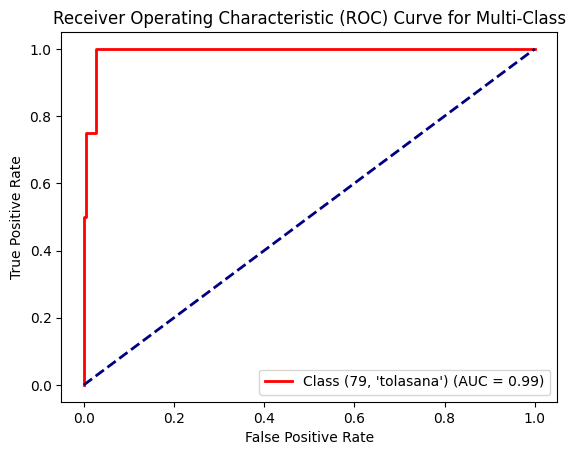

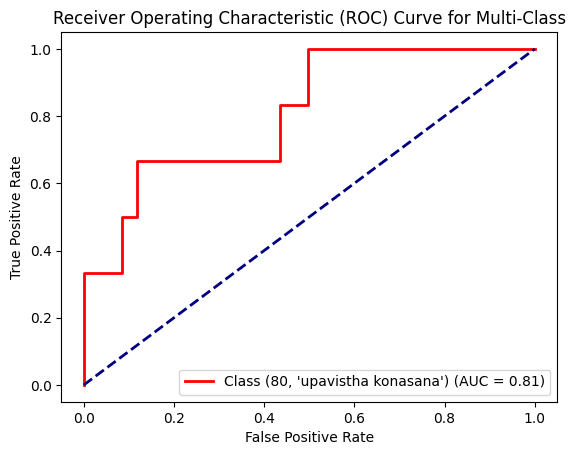

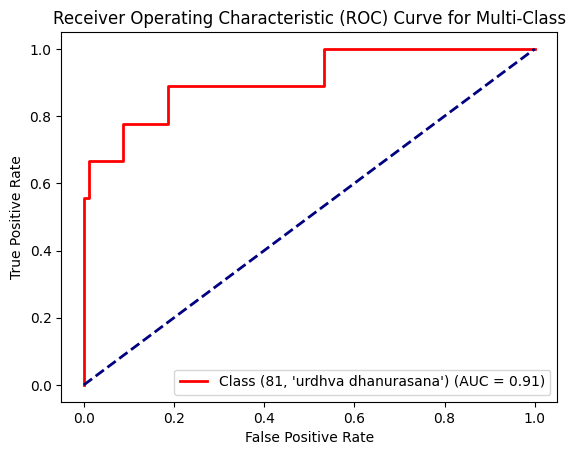

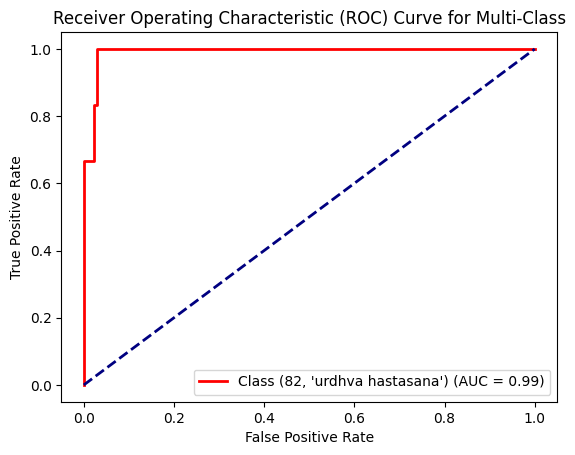

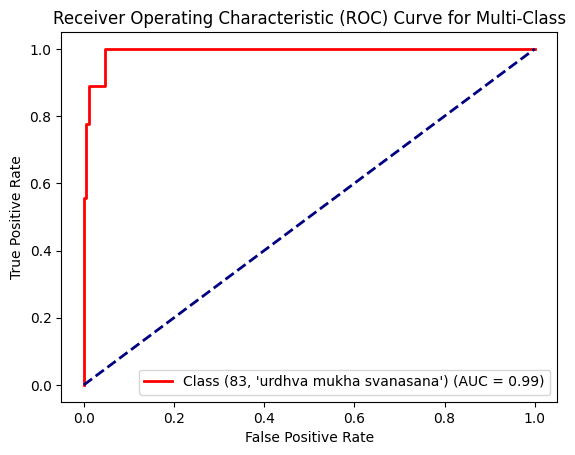

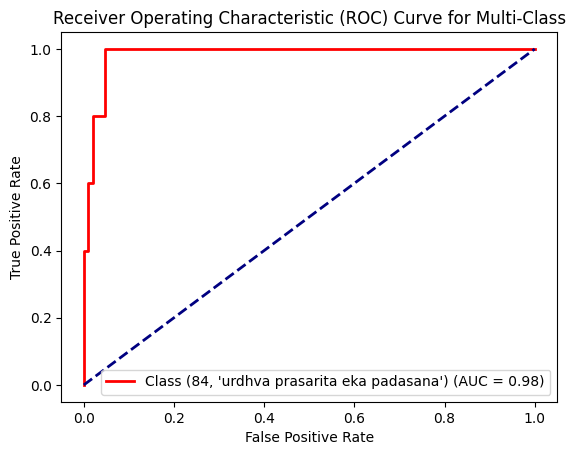

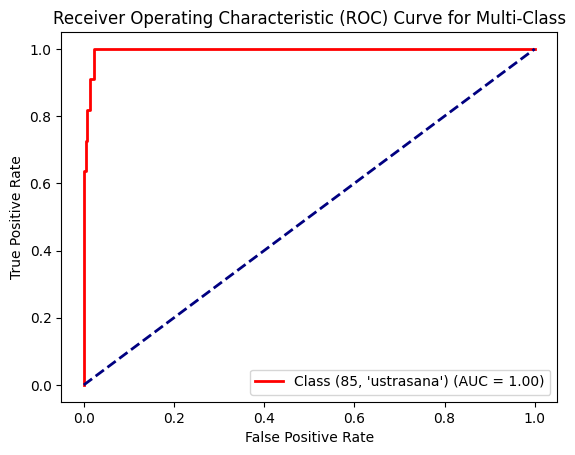

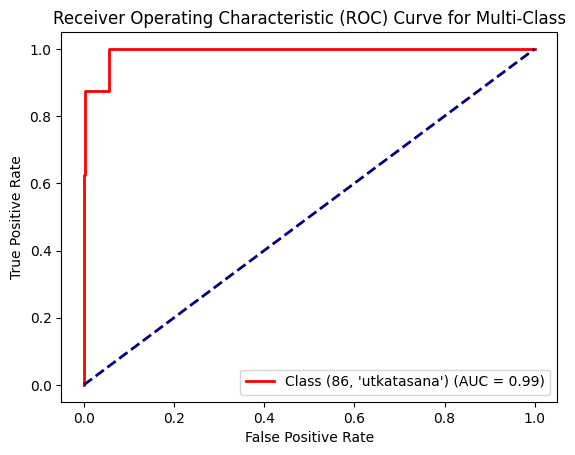

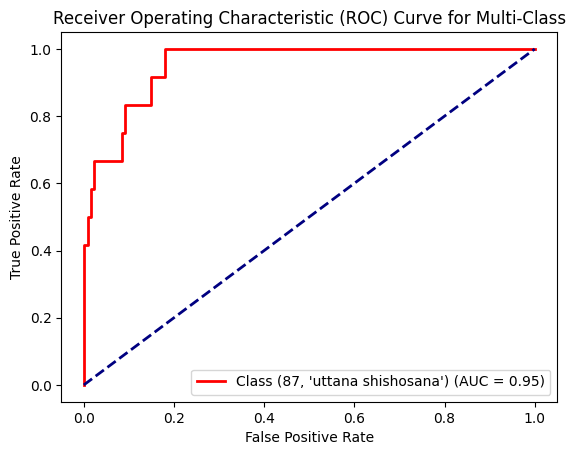

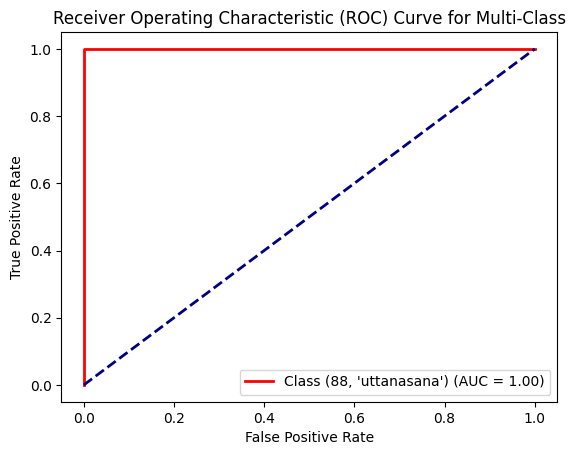

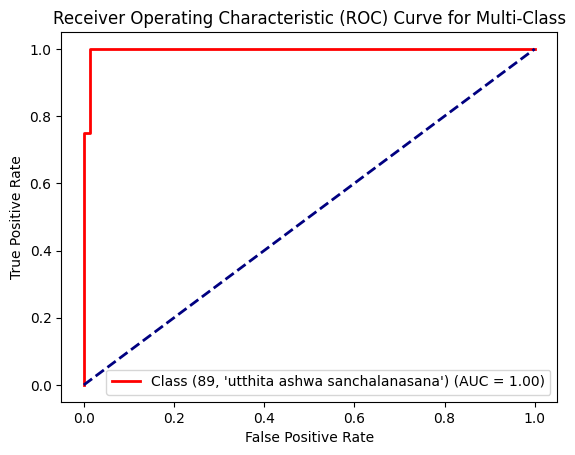

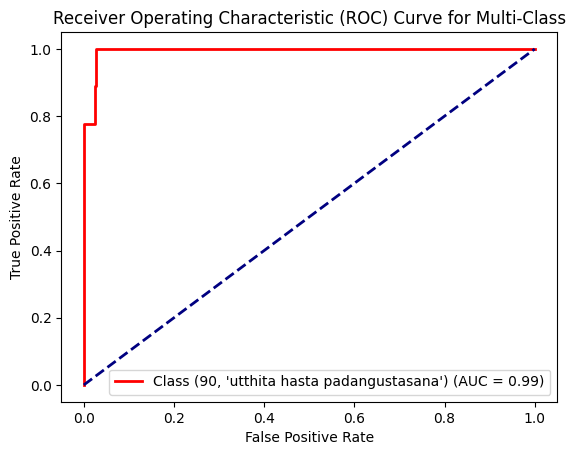

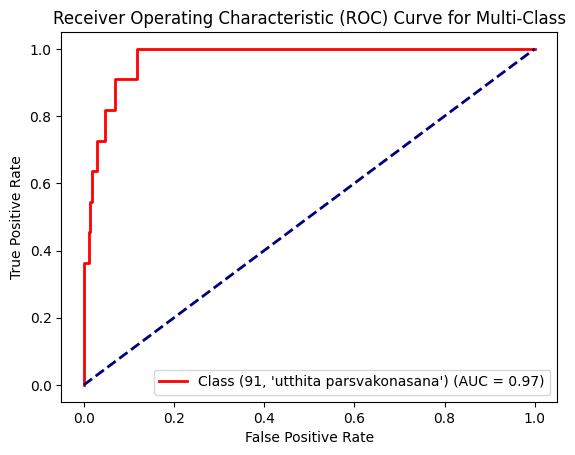

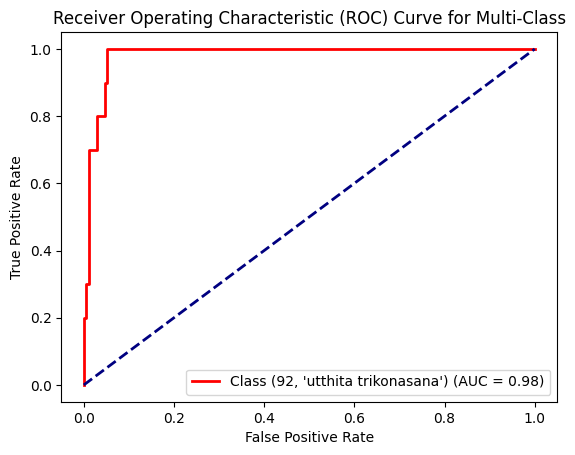

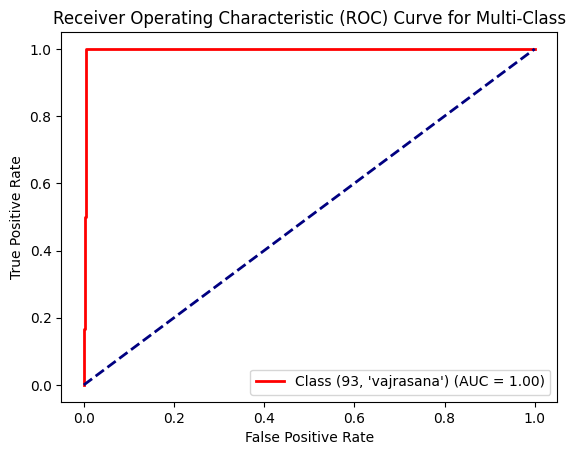

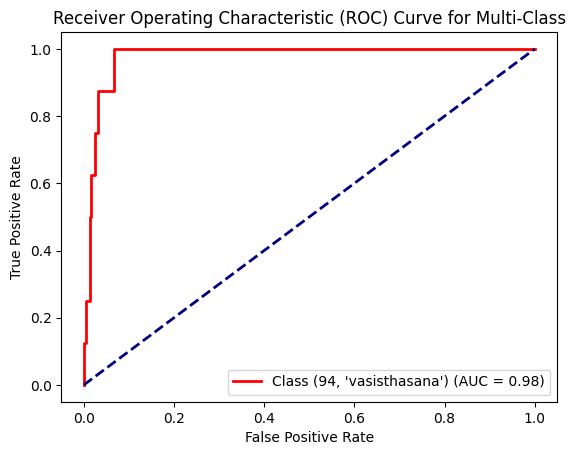

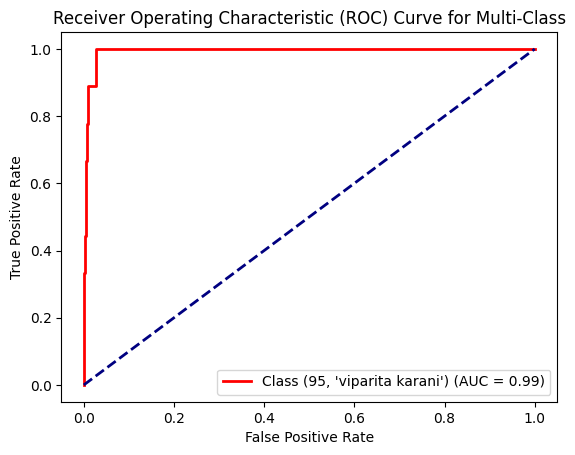

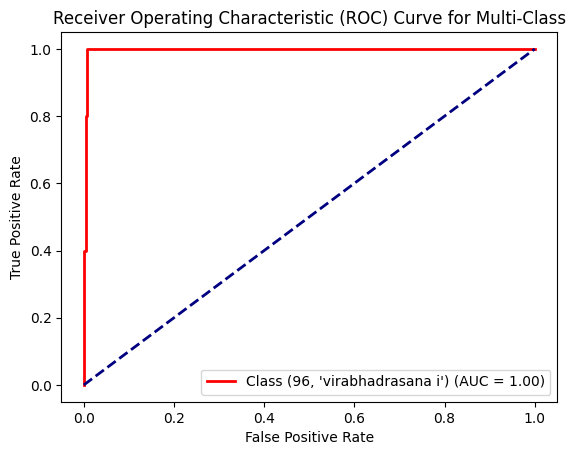

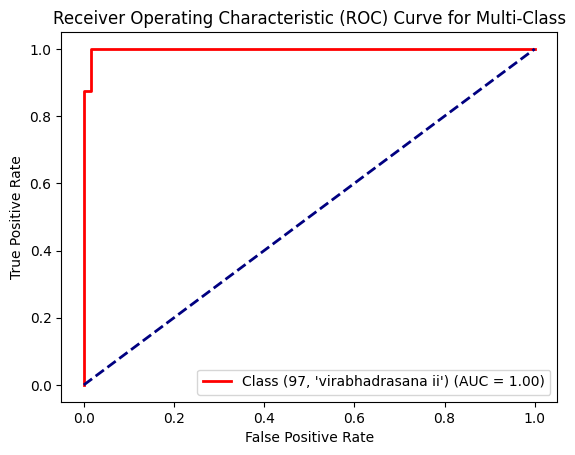

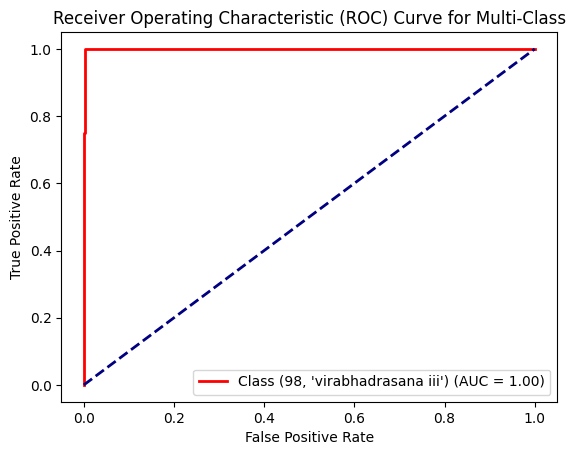

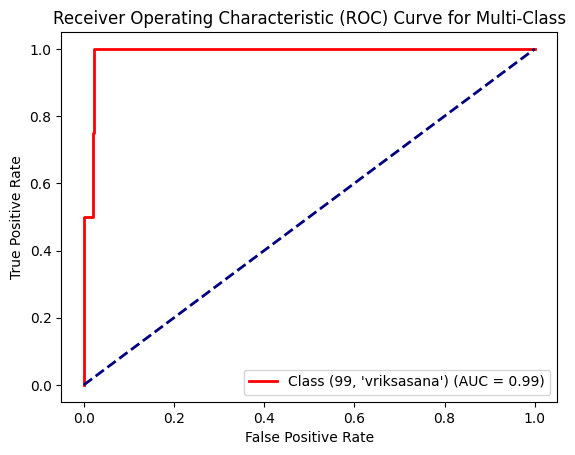

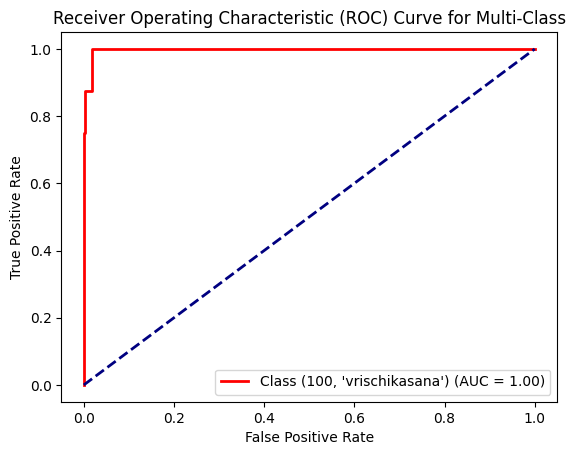

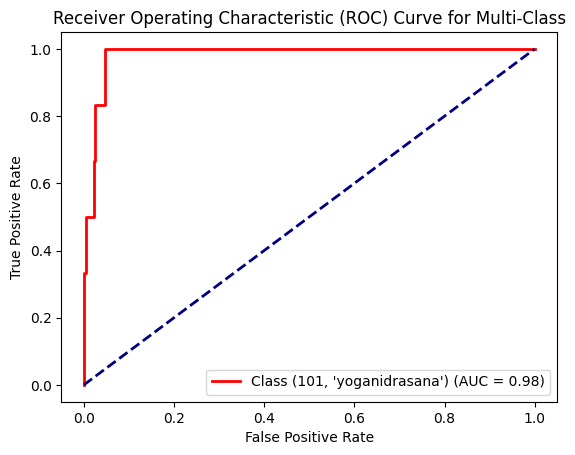

In [63]:
y_true = test_labels_one_hot
y_pred_prob = model.predict(test_data)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 3)) # Add more colors as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color='red', lw=2, label='Class {0} (AUC = {1:0.2f})'.format((i,labels_dict2[i]), roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

In [64]:
pred_labels = np.argmax(y_pred_prob, axis=1)
test_labels = np.argmax(test_labels_one_hot, axis=1)

In [65]:
pred_labels_list = list(pred_labels)
test_labels_list = list(test_labels)

In [66]:
Column1 = []
Column2 = []
for i in range(len(pred_labels_list)):
    if pred_labels_list[i]!=test_labels_list[i]:
        Column1.append(labels_dict2[pred_labels_list[i]])
        Column2.append(labels_dict2[test_labels_list[i]])

In [67]:
wrong = pd.DataFrame( {"Predicted_Position":Column1,"True_Position":Column2})
wrong.sort_values(by=["Predicted_Position"],inplace=True,ignore_index=True)
print(wrong["Predicted_Position"].value_counts().to_string())

Predicted_Position
supta baddha konasana            17
ustrasana                        16
kapotasana                       14
tolasana                         12
ardha matsyendrasana             12
garudasana                       12
parivrtta trikonasana            11
ardha pincha mayurasana          11
purvottanasana                    9
makara adho mukha svanasana       8
janu sirsasana                    8
parighasana                       7
padmasana                         7
malasana                          7
salamba sirsasana                 6
dhanurasana                       6
sukhasana                         6
anantasana                        6
virabhadrasana i                  6
vasisthasana                      6
bakasana                          6
uttana shishosana                 6
makarasana                        5
vriksasana                        5
prasarita padottanasana           5
utthita parsvakonasana            5
phalakasana                       5
kurmasana